# 10.1 GAMLSS Normative Modeling - Completo

## Obiettivo
Implementare un modello normativo completo usando **GAMLSS** (Generalized Additive Models for Location, Scale and Shape) per volumi ippocampali.

## Contenuto
1. Setup e caricamento dati
2. Fitting modello GAMLSS con distribuzione BCT
3. Diagnostica modello
4. Calcolo Z-scores per tutti i soggetti
5. Visualizzazioni avanzate
6. Curve centili per maschi e femmine
7. Salvataggio risultati
8. Esempio applicazione clinica

## Dataset
- **2,289 soggetti sani** dopo QC filtering
- **Età**: 45-95 anni
- **6 dataset**: ADNI, IXI, OASIS-2, OASIS-3, PPMI, SRPBS
- **Target**: Volume ippocampale normalizzato

## 1. Setup e Caricamento Librerie

In [1]:
# Riproducibilità
set.seed(42)

# Carica librerie sopprimendo messaggi di startup
suppressPackageStartupMessages({
  library(gamlss)
  library(gamlss.dist)
  library(ggplot2)
  library(dplyr)
  library(tidyr)
  library(gridExtra)
})

# Crea directory per le figure se non esiste
dir.create("../figures/gamlss", showWarnings = FALSE, recursive = TRUE)
dir.create("../models", showWarnings = FALSE, recursive = TRUE)

cat("✓ Librerie caricate con set.seed(42) per riproducibilità\n")

✓ Librerie caricate con set.seed(42) per riproducibilità


## 2. Caricamento e Preparazione Dati

In [2]:
cat("Caricamento dati...\n")
file_path <- "../data/combined/normative_modeling_dataset.csv"
df <- read.csv(file_path)
target_var <- "vol_total_hippocampus_norm"

# Prepara dataset
df_model <- df %>%
  select(age, sex, dataset, all_of(target_var)) %>%
  na.omit()

# Converti in fattori
df_model$sex <- as.factor(df_model$sex)
df_model$dataset <- as.factor(df_model$dataset)

cat("✓ Dati caricati:\n")
cat("  N soggetti:", nrow(df_model), "\n")
cat("  Range età:", min(df_model$age), "-", max(df_model$age), "\n")
cat("  Femmine:", sum(df_model$sex == "F"), "| Maschi:", sum(df_model$sex == "M"), "\n")
cat("  Datasets:", paste(levels(df_model$dataset), collapse=", "), "\n\n")

# === VALIDAZIONE DATI ===
cat(rep("=", 60), "\n", sep="")
cat("VALIDAZIONE DATI\n")
cat(rep("=", 60), "\n", sep="")

# Check valori mancanti
na_count <- colSums(is.na(df_model))
if(any(na_count > 0)) {
  cat("⚠️ Valori mancanti trovati:\n")
  print(na_count[na_count > 0])
} else {
  cat("✓ Nessun valore mancante\n")
}

# Check outlier estremi (>5 SD)
mean_vol <- mean(df_model[[target_var]])
sd_vol <- sd(df_model[[target_var]])
outliers_5sd <- abs(df_model[[target_var]] - mean_vol) > 5 * sd_vol
outliers_4sd <- abs(df_model[[target_var]] - mean_vol) > 4 * sd_vol

cat("\nOutlier check:\n")
cat("  >4 SD dalla media:", sum(outliers_4sd), "soggetti\n")
cat("  >5 SD dalla media:", sum(outliers_5sd), "soggetti\n")

if(sum(outliers_5sd) > 0) {
  cat("⚠️ Attenzione: outlier estremi potrebbero influenzare il modello\n")
}

# Check distribuzione per dataset
cat("\nDistribuzione per dataset:\n")
print(table(df_model$dataset))

# Check range età per dataset
cat("\nRange età per dataset:\n")
df_model %>%
  group_by(dataset) %>%
  summarise(
    n = n(),
    min_age = min(age),
    max_age = max(age),
    mean_vol = round(mean(!!sym(target_var)), 6)
  ) %>%
  print()

cat(rep("=", 60), "\n", sep="")

# Mostra prime righe
head(df_model)

Caricamento dati...


✓ Dati caricati:
  N soggetti: 2289 
  Range età: 45 - 95 
  Femmine: 1300 | Maschi: 989 
  Datasets: ADNI, IXI, OASIS2, OASIS3, PPMI, SRPBS 

VALIDAZIONE DATI
  N soggetti: 2289 
  Range età: 45 - 95 
  Femmine: 1300 | Maschi: 989 
  Datasets: ADNI, IXI, OASIS2, OASIS3, PPMI, SRPBS 

VALIDAZIONE DATI
✓ Nessun valore mancante

Outlier check:
  >4 SD dalla media: 0 soggetti
  >5 SD dalla media: 0 soggetti

Distribuzione per dataset:

  ADNI    IXI OASIS2 OASIS3   PPMI  SRPBS 
   518    430     85    846    159    251 

Range età per dataset:
✓ Nessun valore mancante

Outlier check:
  >4 SD dalla media: 0 soggetti
  >5 SD dalla media: 0 soggetti

Distribuzione per dataset:

  ADNI    IXI OASIS2 OASIS3   PPMI  SRPBS 
   518    430     85    846    159    251 

Range età per dataset:
# A tibble: 6 × 5
  dataset     n min_age max_age mean_vol
  <fct>   <int>   <dbl>   <dbl>    <dbl>
1 ADNI      518    55.1    89.6  0.00514
2 IXI       430    50.0    86.3  0.00543
3 OASIS2     85    60      

,age,sex,dataset,vol_total_hippocampus_norm
,<dbl>,<fct>,<fct>,<dbl>
1,74.3,M,ADNI,0.004635233
2,73.7,M,ADNI,0.004590722
3,78.5,F,ADNI,0.005050125
4,80.8,M,ADNI,0.004814521
5,65.4,M,ADNI,0.005559864
6,72.6,F,ADNI,0.005342169


## 3. Analisi Esplorativa

Prima di fittare il modello, esploriamo la distribuzione dei dati e la relazione con l'età.

✓ Analisi esplorativa completata


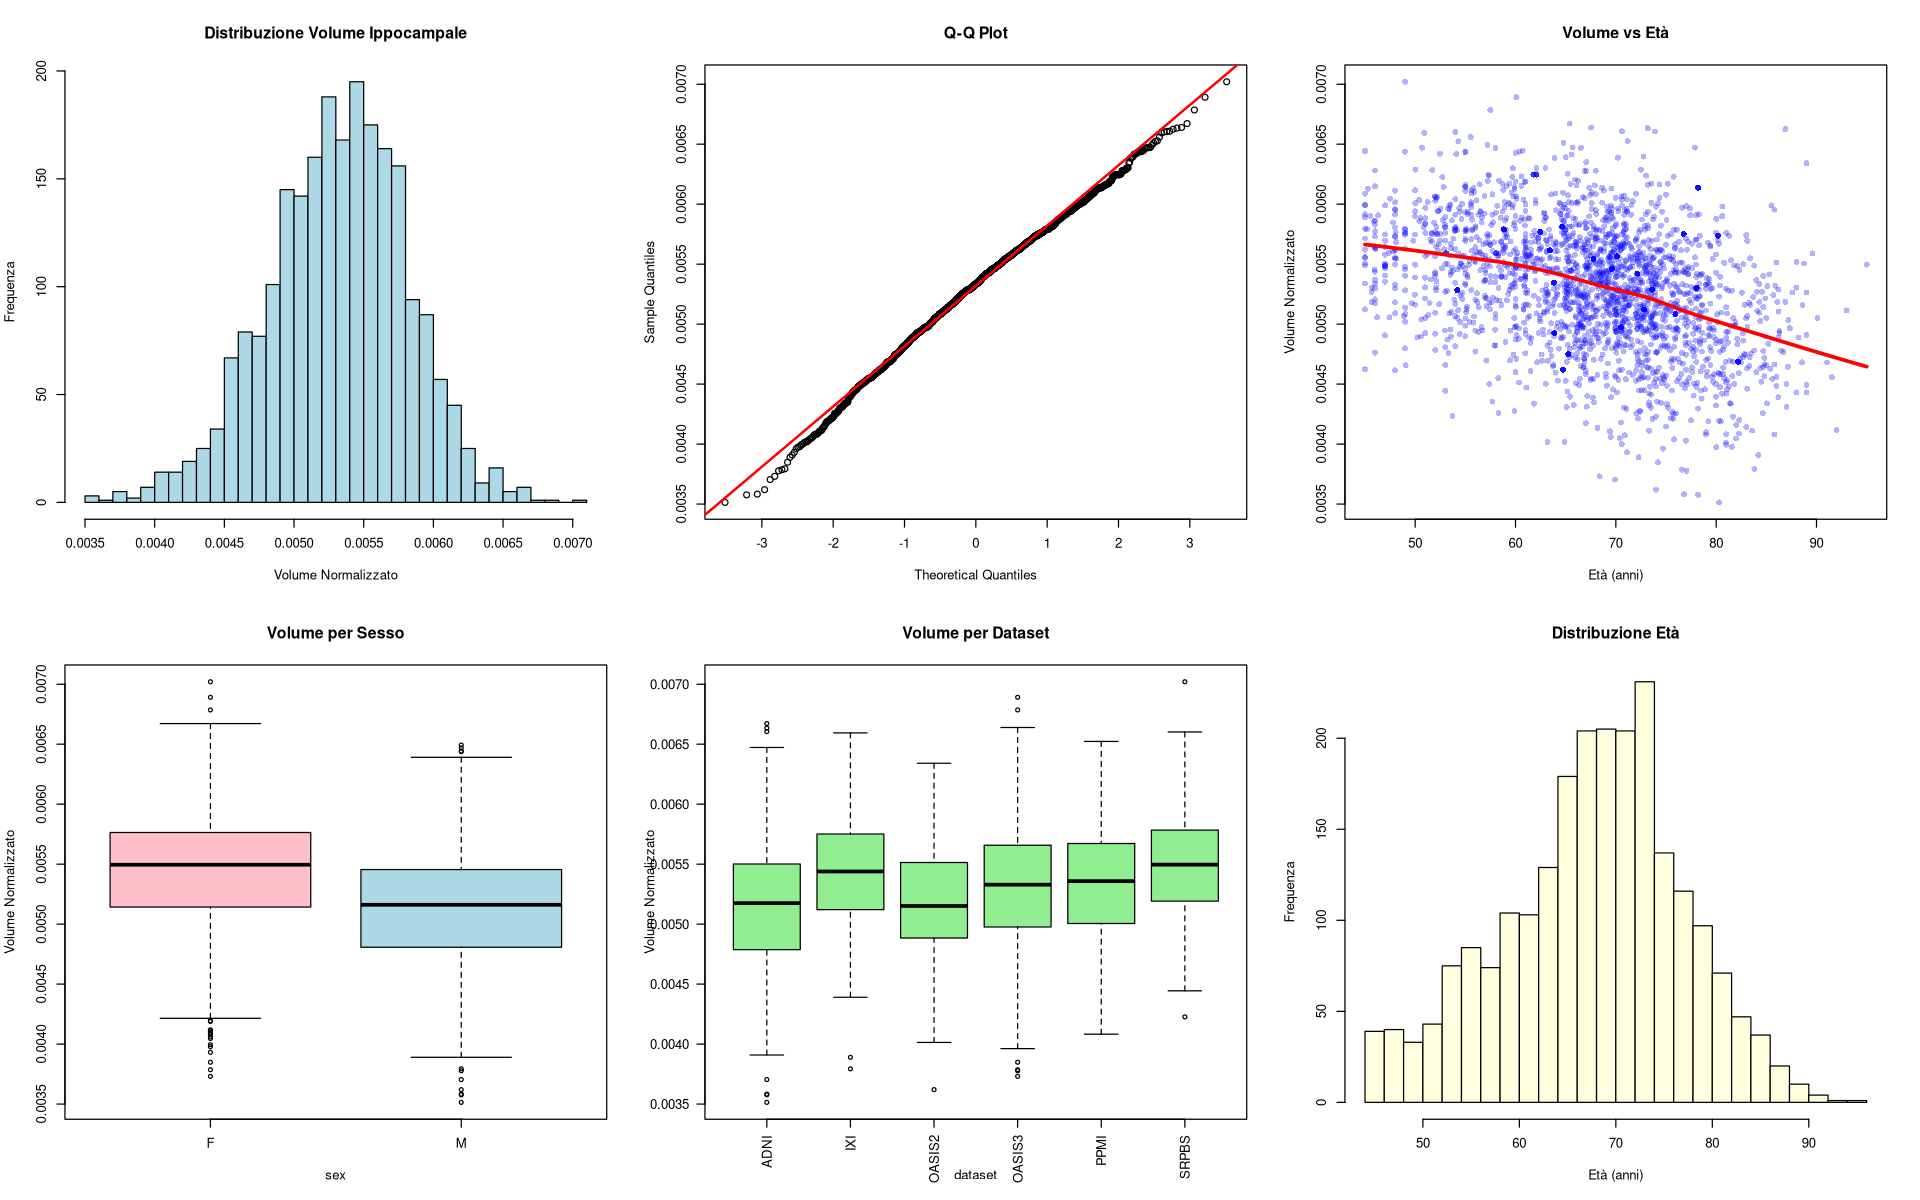

In [3]:
options(repr.plot.width=16, repr.plot.height=10)
par(mfrow=c(2,3))

# 1. Istogramma target
hist(df_model[[target_var]], breaks=50, col="lightblue", main="Distribuzione Volume Ippocampale",
     xlab="Volume Normalizzato", ylab="Frequenza")

# 2. Q-Q plot
qqnorm(df_model[[target_var]], main="Q-Q Plot")
qqline(df_model[[target_var]], col="red", lwd=2)

# 3. Volume vs Età
plot(df_model$age, df_model[[target_var]], pch=16, col=rgb(0,0,1,0.3),
     main="Volume vs Età", xlab="Età (anni)", ylab="Volume Normalizzato")
lines(lowess(df_model$age, df_model[[target_var]]), col="red", lwd=3)

# 4. Volume per Sesso
boxplot(as.formula(paste(target_var, "~ sex")), data=df_model, 
        col=c("pink", "lightblue"), main="Volume per Sesso", ylab="Volume Normalizzato")

# 5. Volume per Dataset
boxplot(as.formula(paste(target_var, "~ dataset")), data=df_model,
        col="lightgreen", main="Volume per Dataset", ylab="Volume Normalizzato", las=2)

# 6. Distribuzione età
hist(df_model$age, breaks=30, col="lightyellow", main="Distribuzione Età",
     xlab="Età (anni)", ylab="Frequenza")

par(mfrow=c(1,1))
cat("✓ Analisi esplorativa completata\n")

## 4. Model Selection e Fitting GAMLSS

### Strategia di Model Selection
Confrontiamo diverse specificazioni del modello GAMLSS per trovare la migliore:

1. **M1 (Base)**: `mu ~ pb(age, df=3) + sex + dataset`, `sigma ~ age` (lineare)
2. **M2 (Sigma non-lineare)**: `mu ~ pb(age) + sex + dataset`, `sigma ~ pb(age)`
3. **M3 (Interazione)**: `mu ~ pb(age, by=sex) + dataset`, `sigma ~ pb(age)`
4. **M4 (Nu variabile)**: Come M2, ma con `nu ~ age`

### Box-Cox t (BCT) Distribution
La distribuzione BCT stima 4 parametri:
- **μ (mu)**: Location (media)
- **σ (sigma)**: Scale (varianza) - modellata per catturare eteroschedasticità
- **ν (nu)**: Skewness (asimmetria)
- **τ (tau)**: Kurtosis (curtosi)

Dove `pb()` = penalized B-splines per relazioni non-lineari con selezione automatica dei gradi di libertà.

In [4]:
cat("=== MODEL SELECTION ===\n")
cat("Fitting e confronto di diversi modelli GAMLSS...\n")
cat("(Questo può richiedere alcuni minuti)\n\n")

# Lista per salvare i modelli
models <- list()

# Controllo comune per tutti i modelli
ctrl <- gamlss.control(n.cyc = 50, trace = FALSE)

# M1: Modello base (sigma lineare, df fisso)
cat("Fitting M1 (base)...\n")
models$M1_base <- tryCatch({
  gamlss(
    formula = as.formula(paste(target_var, "~ pb(age, df=3) + sex + dataset")),
    sigma.formula = ~ age,
    nu.formula = ~ 1,
    tau.formula = ~ 1,
    family = BCT(),
    data = df_model,
    control = ctrl
  )
}, error = function(e) { cat("  Errore M1:", e$message, "\n"); NULL })

# M2: Sigma non-lineare (df automatico)
cat("Fitting M2 (sigma non-lineare)...\n")
models$M2_sigma_pb <- tryCatch({
  gamlss(
    formula = as.formula(paste(target_var, "~ pb(age) + sex + dataset")),
    sigma.formula = ~ pb(age),
    nu.formula = ~ 1,
    tau.formula = ~ 1,
    family = BCT(),
    data = df_model,
    control = ctrl
  )
}, error = function(e) { cat("  Errore M2:", e$message, "\n"); NULL })

# M3: Con interazione età×sesso
cat("Fitting M3 (interazione età×sesso)...\n")
models$M3_interaction <- tryCatch({
  gamlss(
    formula = as.formula(paste(target_var, "~ pb(age) + sex + pb(age):sex + dataset")),
    sigma.formula = ~ pb(age),
    nu.formula = ~ 1,
    tau.formula = ~ 1,
    family = BCT(),
    data = df_model,
    control = ctrl
  )
}, error = function(e) { cat("  Errore M3:", e$message, "\n"); NULL })

# M4: Nu variabile con età
cat("Fitting M4 (nu ~ age)...\n")
models$M4_nu_age <- tryCatch({
  gamlss(
    formula = as.formula(paste(target_var, "~ pb(age) + sex + dataset")),
    sigma.formula = ~ pb(age),
    nu.formula = ~ age,
    tau.formula = ~ 1,
    family = BCT(),
    data = df_model,
    control = ctrl
  )
}, error = function(e) { cat("  Errore M4:", e$message, "\n"); NULL })

# Rimuovi modelli falliti
models <- models[!sapply(models, is.null)]

cat("\n✓ Modelli fittati con successo:", length(models), "/4\n\n")

# === CONFRONTO MODELLI ===
cat(rep("=", 80), "\n", sep="")
cat("CONFRONTO MODELLI (GAIC con k=log(n) per BIC)\n")
cat(rep("=", 80), "\n", sep="")

if(length(models) > 1) {
  # Calcola metriche per ogni modello
  comparison <- data.frame(
    Model = names(models),
    AIC = sapply(models, AIC),
    BIC = sapply(models, function(m) GAIC(m, k = log(nrow(df_model)))),
    Deviance = sapply(models, deviance),
    df_used = sapply(models, function(m) m$df.fit)
  )
  
  # Ordina per BIC
  comparison <- comparison[order(comparison$BIC), ]
  comparison$Delta_BIC <- comparison$BIC - min(comparison$BIC)
  
  print(comparison)
  
  # Seleziona il migliore (BIC più basso)
  best_model_name <- comparison$Model[1]
  cat("\n✓ Modello selezionato (BIC più basso):", best_model_name, "\n")
  
  model_final <- models[[best_model_name]]
} else {
  cat("Solo un modello disponibile, uso quello.\n")
  model_final <- models[[1]]
  best_model_name <- names(models)[1]
}

cat("\n", rep("=", 80), "\n", sep="")
cat("SUMMARY MODELLO FINALE:", best_model_name, "\n")
cat(rep("=", 80), "\n", sep="")
cat("  AIC:", round(AIC(model_final), 2), "\n")
cat("  BIC:", round(GAIC(model_final, k = log(nrow(df_model))), 2), "\n")
cat("  Deviance:", round(deviance(model_final), 2), "\n")
cat("  df utilizzati:", round(model_final$df.fit, 1), "\n")

summary(model_final)

=== MODEL SELECTION ===
Fitting e confronto di diversi modelli GAMLSS...
(Questo può richiedere alcuni minuti)

Fitting M1 (base)...
Fitting e confronto di diversi modelli GAMLSS...
(Questo può richiedere alcuni minuti)

Fitting M1 (base)...
Fitting M2 (sigma non-lineare)...
Fitting M2 (sigma non-lineare)...
Fitting M3 (interazione età×sesso)...
Fitting M3 (interazione età×sesso)...
Fitting M4 (nu ~ age)...
Fitting M4 (nu ~ age)...

✓ Modelli fittati con successo: 4 /4

CONFRONTO MODELLI (GAIC con k=log(n) per BIC)
                        Model       AIC       BIC  Deviance  df_used Delta_BIC
M1_base               M1_base -28898.93 -28812.89 -28928.93 15.00000   0.00000
M2_sigma_pb       M2_sigma_pb -28902.47 -28762.58 -28951.24 24.38747  50.30204
M3_interaction M3_interaction -28901.12 -28755.52 -28951.89 25.38504  57.37148
M4_nu_age           M4_nu_age -28900.50 -28754.91 -28951.26 25.38282  57.98042

✓ Modello selezionato (BIC più basso): M1_base 

✓ Modelli fittati con successo: 4 

Warning message in summary.gamlss(model_final):
“summary: vcov has failed, option qr is used instead
”


******************************************************************
Family:  c("BCT", "Box-Cox t") 

Call:  
gamlss(formula = as.formula(paste(target_var, "~ pb(age, df=3) + sex + dataset")),  
    sigma.formula = ~age, nu.formula = ~1, tau.formula = ~1,  
    family = BCT(), data = df_model, control = ctrl) 

Fitting method: RS() 

------------------------------------------------------------------
Mu link function:  identity
Mu Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      6.571e-03  8.276e-05  79.397  < 2e-16 ***
pb(age, df = 3) -1.738e-05  1.111e-06 -15.639  < 2e-16 ***
sexM            -2.812e-04  1.806e-05 -15.571  < 2e-16 ***
datasetIXI       9.232e-05  2.940e-05   3.141  0.00171 ** 
datasetOASIS2   -2.349e-06  5.201e-05  -0.045  0.96398    
datasetOASIS3    5.218e-05  2.494e-05   2.092  0.03651 *  
datasetPPMI      8.675e-05  3.958e-05   2.192  0.02849 *  
datasetSRPBS     4.666e-05  3.687e-05   1.265  0.20583    
---
Signif. codes:  0 ‘

## 5. Diagnostica Modello

******************************************************************
	      Summary of the Quantile Residuals
                           mean   =  -9.31318e-05 
                       variance   =  1.000742 
               coef. of skewness  =  0.002782185 
               coef. of kurtosis  =  2.98383 
Filliben correlation coefficient  =  0.9995761 
******************************************************************


******************************************************************
	      Summary of the Quantile Residuals
                           mean   =  -9.31318e-05 
                       variance   =  1.000742 
               coef. of skewness  =  0.002782185 
               coef. of kurtosis  =  2.98383 
Filliben correlation coefficient  =  0.9995761 
******************************************************************


pdf 
  2

✓ Diagnostic plots salvati


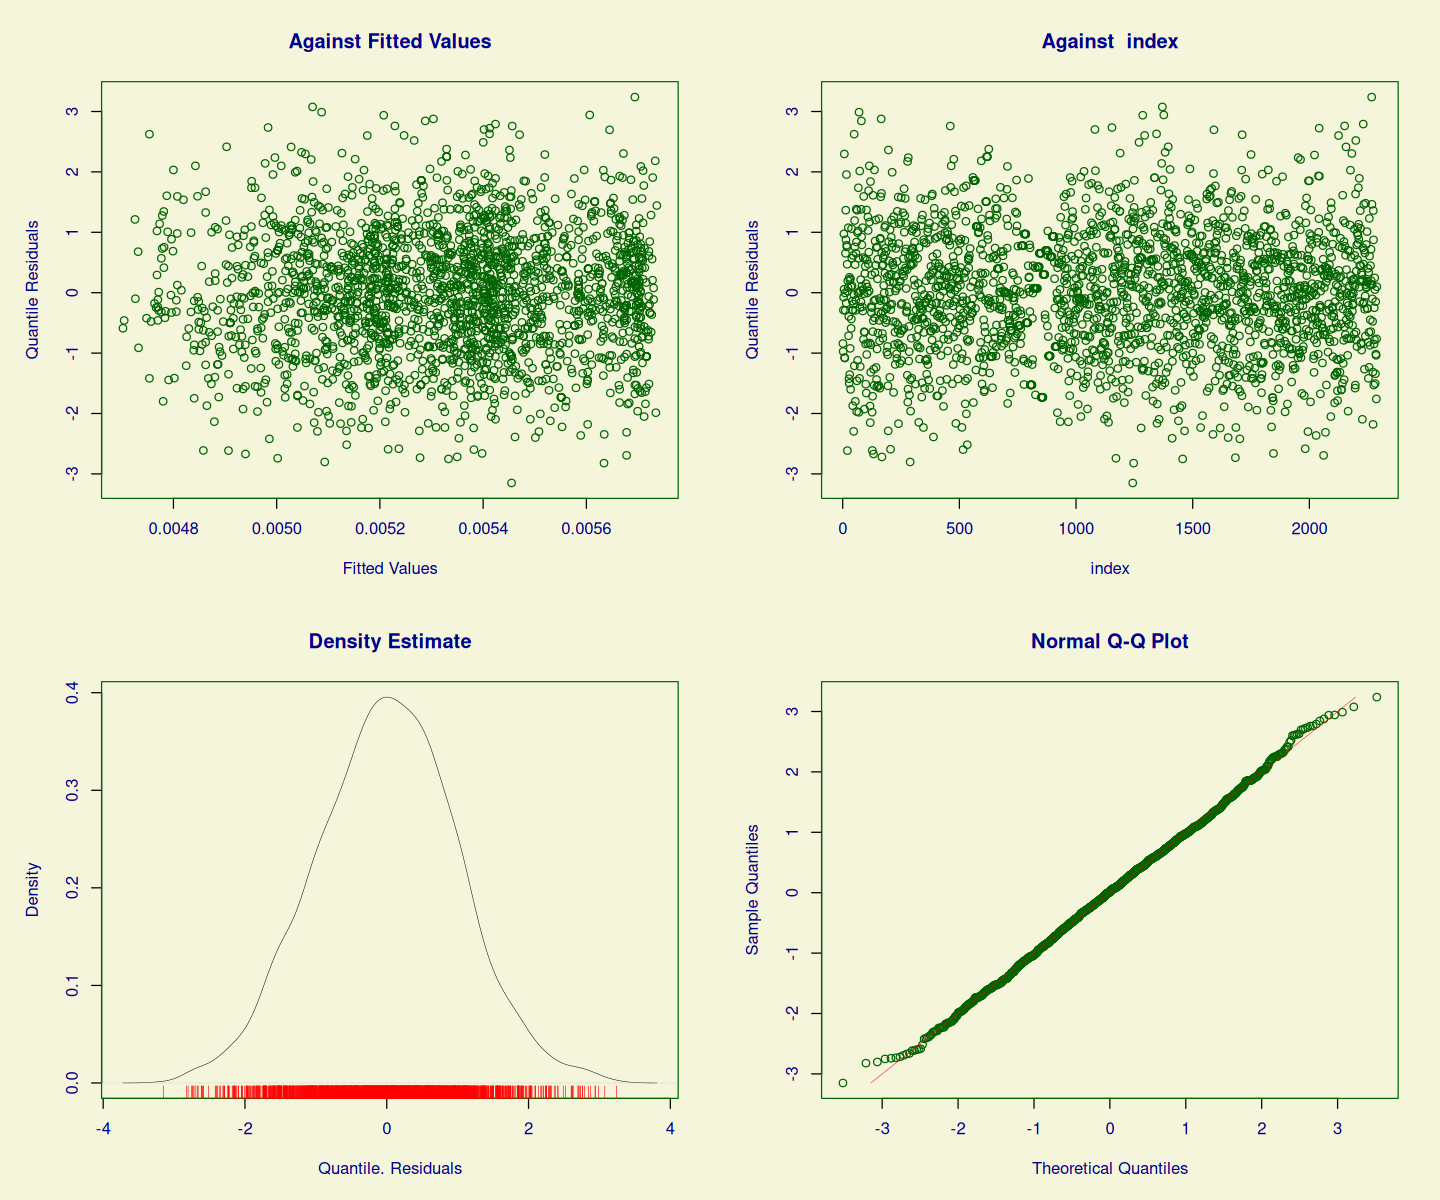

In [5]:
# Plot diagnostici standard
options(repr.plot.width=12, repr.plot.height=10)
plot(model_final)

# Salva anche su file
png("../figures/gamlss/model_diagnostics_bct.png", width=12, height=10, units="in", res=300)
plot(model_final)
dev.off()

cat("✓ Diagnostic plots salvati\n")

pdf 
  2

✓ Worm plots salvati


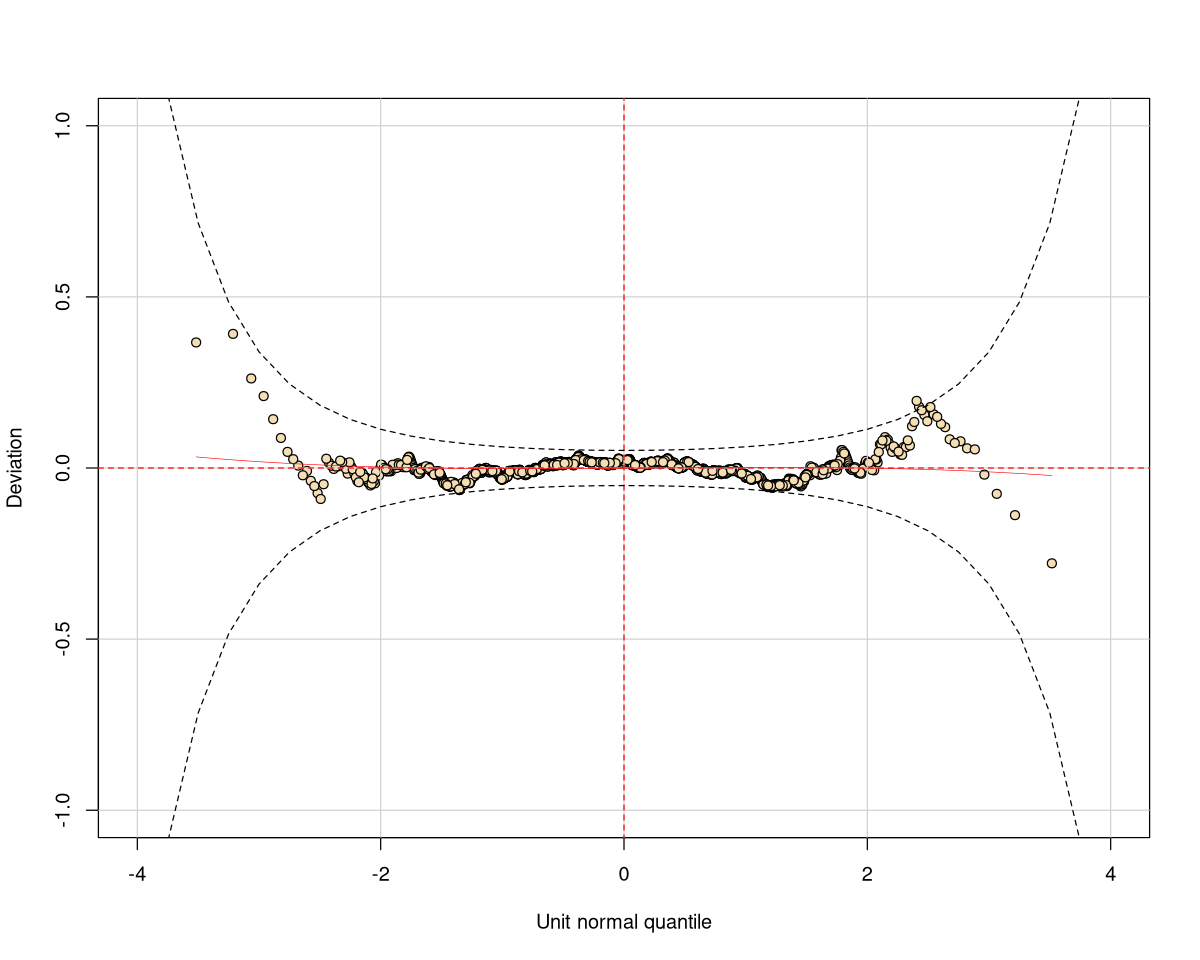

In [6]:
# Worm plots - diagnostica specifica GAMLSS
options(repr.plot.width=10, repr.plot.height=8)
wp(model_final, ylim.all = 1)

# Salva su file
png("../figures/gamlss/worm_plots_bct.png", width=10, height=8, units="in", res=300)
wp(model_final, ylim.all = 1)
dev.off()

cat("✓ Worm plots salvati\n")

## 6. Calcolo Z-scores

Calcoliamo gli Z-scores per tutti i soggetti usando il modello BCT finale. Gli Z-scores rappresentano quante deviazioni standard un soggetto si discosta dal valore atteso per la sua età, sesso e dataset.

In [7]:
cat("Calcolo Z-scores per tutti i soggetti...\n")

# SOLUZIONE: centiles.pred() ha un bug e non passa correttamente 'data' a predict()
# Calcoliamo manualmente gli Z-scores usando le predizioni del modello GAMLSS

# 1. Ottieni le predizioni per tutti i parametri della distribuzione BCT
df_model$fitted_mu <- predict(model_final, what = "mu", type = "response")
df_model$fitted_sigma <- predict(model_final, what = "sigma", type = "response")
df_model$fitted_nu <- predict(model_final, what = "nu", type = "response")
df_model$fitted_tau <- predict(model_final, what = "tau", type = "response")

# 2. Calcola Z-scores usando la funzione qBCT (quantile della distribuzione BCT)
# Per ogni osservazione, calcoliamo il quantile nella distribuzione BCT e poi convertiamo in z-score normale
library(gamlss.dist)

# Calcola il quantile (percentile) di ogni osservazione nella sua distribuzione predetta
df_model$percentile <- pBCT(
  q = df_model[[target_var]],      # Valori osservati
  mu = df_model$fitted_mu,          # μ predetto
  sigma = df_model$fitted_sigma,    # σ predetto
  nu = df_model$fitted_nu,          # ν predetto
  tau = df_model$fitted_tau         # τ predetto
)

# Converti percentile in z-score usando la distribuzione normale
df_model$z_score <- qnorm(df_model$percentile)

# Gestisci valori estremi (percentile = 0 o 1 → z infinito)
df_model$z_score[df_model$percentile <= 0.0001] <- -4
df_model$z_score[df_model$percentile >= 0.9999] <- 4

cat("✓ Z-scores calcolati manualmente\n")

# Statistiche Z-scores
cat("\n", rep("=", 80), "\n", sep="")
cat("STATISTICHE Z-SCORES\n")
cat(rep("=", 80), "\n", sep="")
cat("Media:   ", round(mean(df_model$z_score, na.rm=TRUE), 4), "\n")
cat("SD:      ", round(sd(df_model$z_score, na.rm=TRUE), 4), "\n")
cat("Mediana: ", round(median(df_model$z_score, na.rm=TRUE), 4), "\n")
cat("Min:     ", round(min(df_model$z_score, na.rm=TRUE), 2), "\n")
cat("Max:     ", round(max(df_model$z_score, na.rm=TRUE), 2), "\n")

# Conta valori estremi
cat("\nValori estremi:\n")
cat("  Z < -3:     ", sprintf("%4d", sum(df_model$z_score < -3, na.rm=TRUE)), " soggetti (",
    sprintf("%4.1f", sum(df_model$z_score < -3, na.rm=TRUE) / nrow(df_model) * 100), "%)\n")
cat("  Z < -2:     ", sprintf("%4d", sum(df_model$z_score < -2, na.rm=TRUE)), " soggetti (",
    sprintf("%4.1f", sum(df_model$z_score < -2, na.rm=TRUE) / nrow(df_model) * 100), "%)\n")
cat("  -2 ≤ Z ≤ 2: ", sprintf("%4d", sum(df_model$z_score >= -2 & df_model$z_score <= 2, na.rm=TRUE)), " soggetti (",
    sprintf("%4.1f", sum(df_model$z_score >= -2 & df_model$z_score <= 2, na.rm=TRUE) / nrow(df_model) * 100), "%)\n")
cat("  Z > +2:     ", sprintf("%4d", sum(df_model$z_score > 2, na.rm=TRUE)), " soggetti (",
    sprintf("%4.1f", sum(df_model$z_score > 2, na.rm=TRUE) / nrow(df_model) * 100), "%)\n")
cat("  Z > +3:     ", sprintf("%4d", sum(df_model$z_score > 3, na.rm=TRUE)), " soggetti (",
    sprintf("%4.1f", sum(df_model$z_score > 3, na.rm=TRUE) / nrow(df_model) * 100), "%)\n")

# Mostra distribuzione dei percentili
cat("\nDistribuzione percentili (dovrebbe essere uniforme):\n")
cat("  0-20%:   ", sum(df_model$percentile <= 0.2, na.rm=TRUE), "\n")
cat("  20-40%:  ", sum(df_model$percentile > 0.2 & df_model$percentile <= 0.4, na.rm=TRUE), "\n")
cat("  40-60%:  ", sum(df_model$percentile > 0.4 & df_model$percentile <= 0.6, na.rm=TRUE), "\n")
cat("  60-80%:  ", sum(df_model$percentile > 0.6 & df_model$percentile <= 0.8, na.rm=TRUE), "\n")
cat("  80-100%: ", sum(df_model$percentile > 0.8, na.rm=TRUE), "\n")

cat(rep("=", 80), "\n", sep="")

Calcolo Z-scores per tutti i soggetti...


✓ Z-scores calcolati manualmente

STATISTICHE Z-SCORES
Media:    -1e-04 
SD:       1.0004 
Mediana:  0.0132 
Min:      -3.15 
Max:      3.24 

Valori estremi:
  Z < -3:         1  soggetti (  0.0 %)
  Z < -2:        52  soggetti (  2.3 %)

STATISTICHE Z-SCORES
Media:    -1e-04 
SD:       1.0004 
Mediana:  0.0132 
Min:      -3.15 
Max:      3.24 

Valori estremi:
  Z < -3:         1  soggetti (  0.0 %)
  Z < -2:        52  soggetti (  2.3 %)
  -2 ≤ Z ≤ 2:  2183  soggetti ( 95.4 %)
  Z > +2:        54  soggetti (  2.4 %)
  Z > +3:         2  soggetti (  0.1 %)

Distribuzione percentili (dovrebbe essere uniforme):
  0-20%:    465 
  20-40%:   436 
  40-60%:   457 
  60-80%:   480 
  80-100%:  451 
  -2 ≤ Z ≤ 2:  2183  soggetti ( 95.4 %)
  Z > +2:        54  soggetti (  2.4 %)
  Z > +3:         2  soggetti (  0.1 %)

Distribuzione percentili (dovrebbe essere uniforme):
  0-20%:    465 
  20-40%:   436 
  40-60%:   457 
  60-80%:   480 
  80-100%:  451 


## 7. Visualizzazione Z-scores

pdf 
  2

✓ Z-scores visualizations salvate


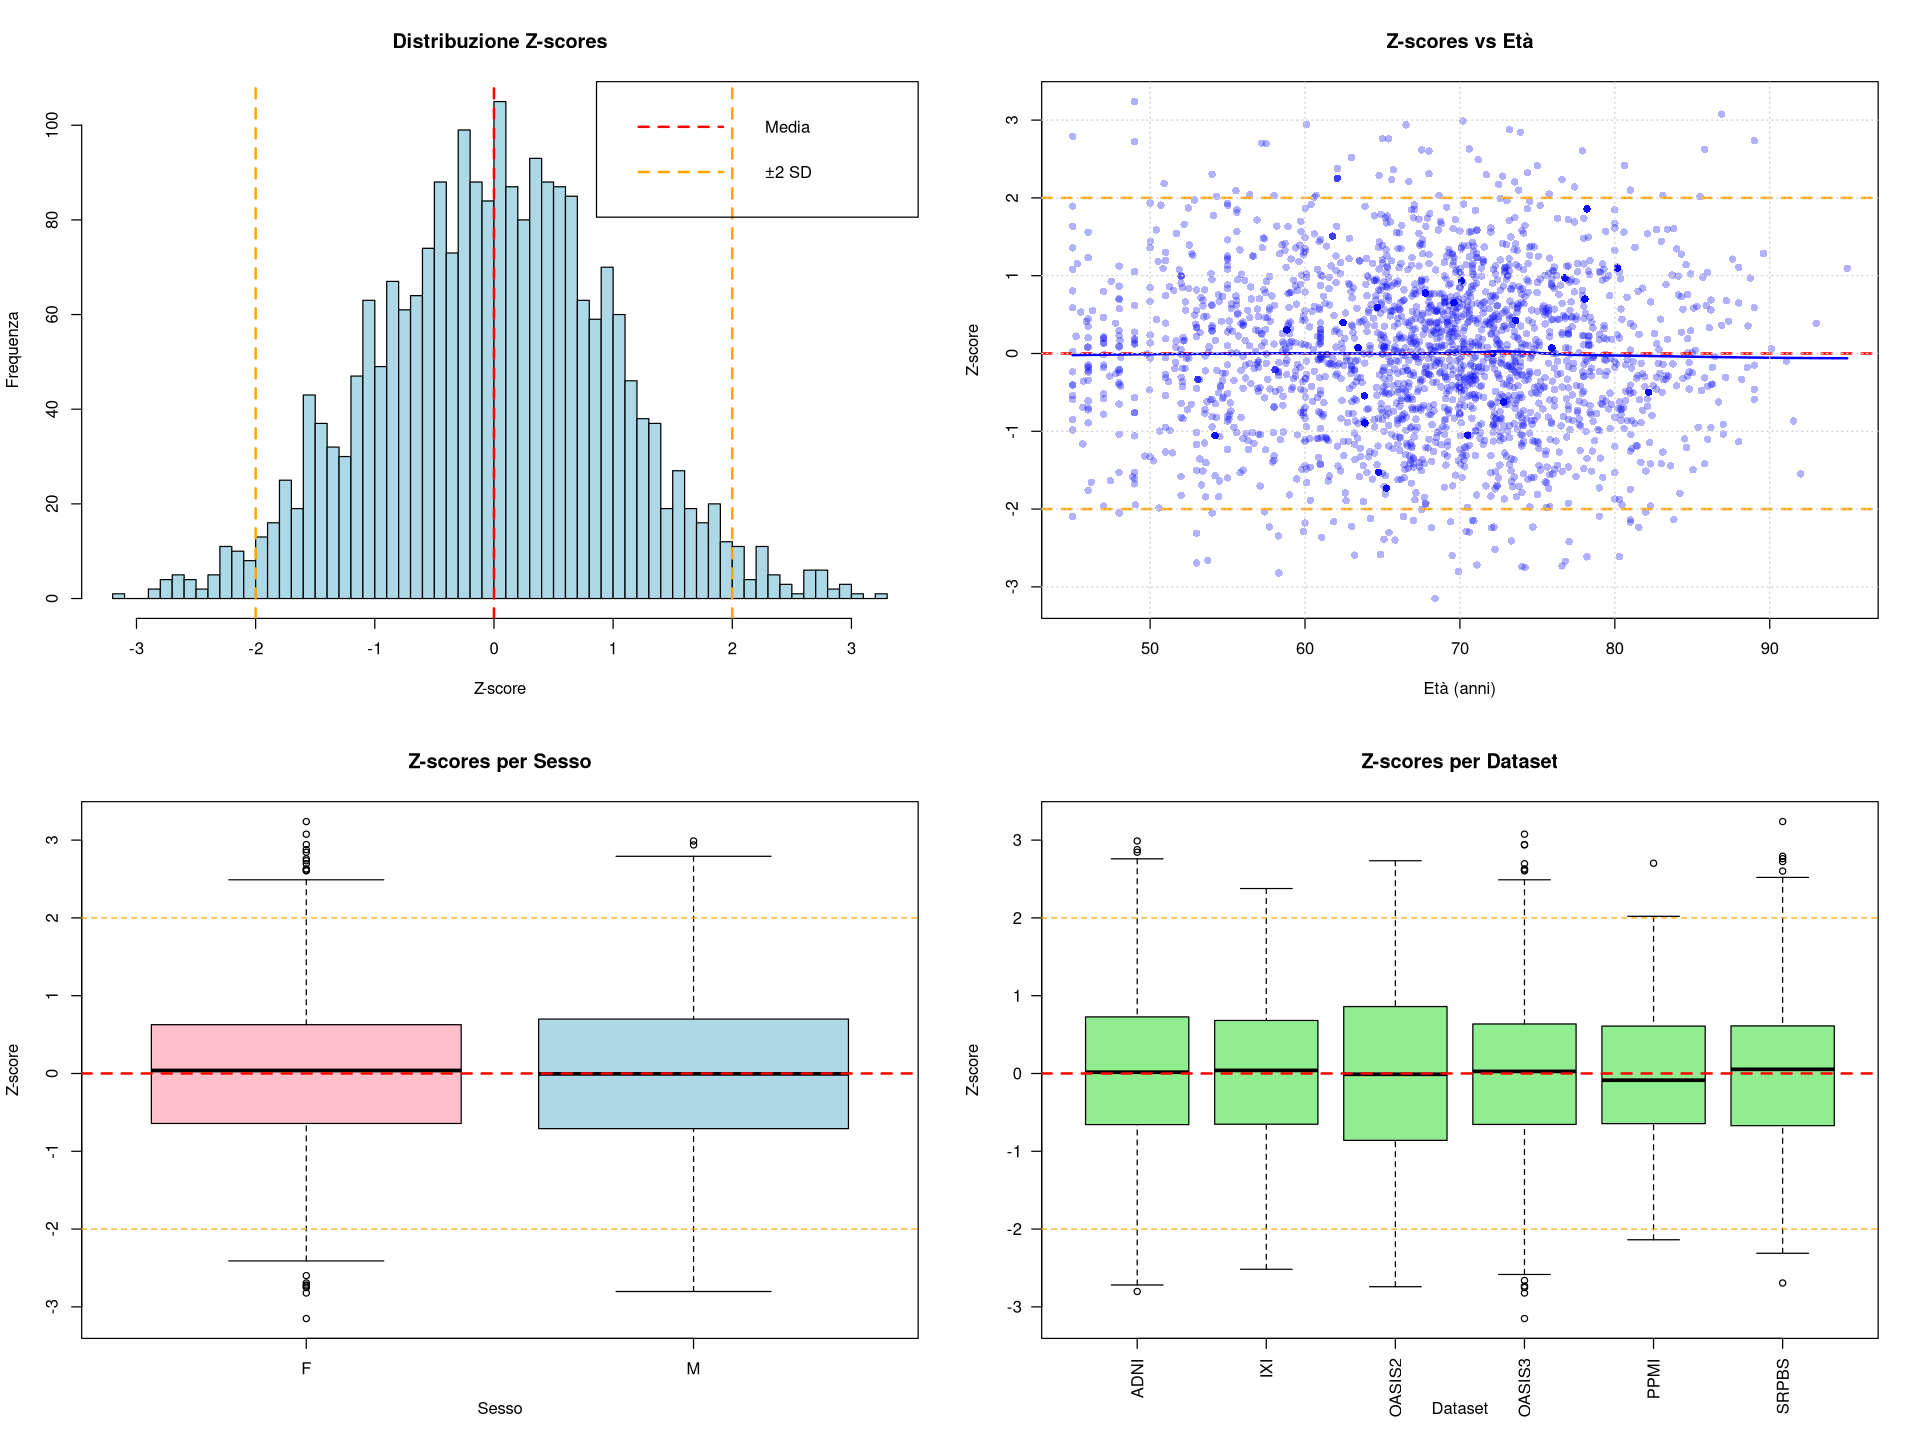

In [8]:
options(repr.plot.width=16, repr.plot.height=12)
par(mfrow=c(2,2))

# 1. Istogramma Z-scores
hist(df_model$z_score, breaks=50, col="lightblue",
     main="Distribuzione Z-scores", xlab="Z-score", ylab="Frequenza")
abline(v=0, col="red", lwd=2, lty=2)
abline(v=c(-2, 2), col="orange", lwd=2, lty=2)
legend("topright", legend=c("Media", "±2 SD"),
       col=c("red", "orange"), lty=2, lwd=2)

# 2. Z-scores vs Age
plot(df_model$age, df_model$z_score, pch=16, col=rgb(0,0,1,0.3),
     main="Z-scores vs Età", xlab="Età (anni)", ylab="Z-score")
abline(h=0, col="red", lwd=2, lty=2)
abline(h=c(-2, 2), col="orange", lwd=2, lty=2)
lines(lowess(df_model$age, df_model$z_score), col="blue", lwd=2)
grid()

# 3. Z-scores by Sex
boxplot(z_score ~ sex, data=df_model, col=c("pink", "lightblue"),
        main="Z-scores per Sesso", xlab="Sesso", ylab="Z-score")
abline(h=0, col="red", lwd=2, lty=2)
abline(h=c(-2, 2), col="orange", lwd=1, lty=2)

# 4. Z-scores by Dataset
boxplot(z_score ~ dataset, data=df_model, col="lightgreen",
        main="Z-scores per Dataset", xlab="Dataset", ylab="Z-score", las=2)
abline(h=0, col="red", lwd=2, lty=2)
abline(h=c(-2, 2), col="orange", lwd=1, lty=2)

par(mfrow=c(1,1))

# Salva su file
png("../figures/gamlss/z_scores_analysis.png", width=16, height=12, units="in", res=300)
par(mfrow=c(2,2))
hist(df_model$z_score, breaks=50, col="lightblue",
     main="Distribuzione Z-scores", xlab="Z-score", ylab="Frequenza")
abline(v=0, col="red", lwd=2, lty=2)
abline(v=c(-2, 2), col="orange", lwd=2, lty=2)
legend("topright", legend=c("Media", "±2 SD"), col=c("red", "orange"), lty=2, lwd=2)
plot(df_model$age, df_model$z_score, pch=16, col=rgb(0,0,1,0.3),
     main="Z-scores vs Età", xlab="Età (anni)", ylab="Z-score")
abline(h=0, col="red", lwd=2, lty=2)
abline(h=c(-2, 2), col="orange", lwd=2, lty=2)
lines(lowess(df_model$age, df_model$z_score), col="blue", lwd=2)
grid()
boxplot(z_score ~ sex, data=df_model, col=c("pink", "lightblue"),
        main="Z-scores per Sesso", xlab="Sesso", ylab="Z-score")
abline(h=0, col="red", lwd=2, lty=2)
abline(h=c(-2, 2), col="orange", lwd=1, lty=2)
boxplot(z_score ~ dataset, data=df_model, col="lightgreen",
        main="Z-scores per Dataset", xlab="Dataset", ylab="Z-score", las=2)
abline(h=0, col="red", lwd=2, lty=2)
abline(h=c(-2, 2), col="orange", lwd=1, lty=2)
par(mfrow=c(1,1))
dev.off()

cat("✓ Z-scores visualizations salvate\n")

## 8. Curve Centili Stratificate per Dataset

✅ **Approccio corretto per gestire l'effetto dataset:**

Invece di armonizzare i dati, manteniamo il modello GAMLSS con `dataset` come predittore e generiamo **curve centili stratificate** per ogni combinazione dataset×sesso.

**Perché questo approccio è corretto:**
- Gli Z-scores calcolati nella sezione 6 sono **già corretti** - ogni soggetto è confrontato con la distribuzione del suo dataset
- Le curve centili stratificate mostrano la variabilità specifica di ogni dataset
- Ogni paziente viene valutato rispetto alla curva del suo sito di acquisizione

**Uso clinico:**
Per un nuovo paziente, identificare il dataset di provenienza (es. ADNI) e confrontare con le curve specifiche.

In [9]:
# Libreria necessaria per i quantili BCT
library(gamlss.dist)

# Impostazioni grafiche
png("../figures/gamlss/centile_curves_stratified_clean.png", width=18, height=24, units="in", res=300)
par(mfrow=c(4,3), mar=c(4,4,3,1), cex.main=1.2, cex.lab=1.1, cex.axis=1.0)

datasets_list <- levels(df_model$dataset)

for(ds in datasets_list) {
  for(sx in c("M", "F")) {
    
    # 1. Dati reali (solo per i pallini di sfondo)
    df_subset <- df_model[df_model$dataset == ds & df_model$sex == sx, ]
    
    # Procediamo solo se ci sono abbastanza dati
    if(nrow(df_subset) > 10) {
      
      # 2. Creiamo dati "FINTI" per interrogare il modello (per le linee lisce)
      # Creiamo una sequenza di età fluida dal min al max di QUESTO sottogruppo
      age_seq <- seq(min(df_subset$age), max(df_subset$age), length.out = 200)
      
      newdata <- data.frame(
        age = age_seq,
        sex = factor(sx, levels = levels(df_model$sex)),       # Fissiamo il sesso
        dataset = factor(ds, levels = levels(df_model$dataset)) # Fissiamo il dataset
      )
      
      # 3. Prediciamo i parametri Mu, Sigma, Nu, Tau su questi dati puliti
      # Nota: type="response" ci dà i valori trasformati pronti all'uso
      mu_pred <- predict(model_final, newdata = newdata, what = "mu", type = "response")
      sigma_pred <- predict(model_final, newdata = newdata, what = "sigma", type = "response")
      nu_pred <- predict(model_final, newdata = newdata, what = "nu", type = "response")
      tau_pred <- predict(model_final, newdata = newdata, what = "tau", type = "response")
      
      # 4. Calcoliamo i centili teorici (5%, 25%, 50%, 75%, 95%)
      p05 <- qBCT(0.05, mu=mu_pred, sigma=sigma_pred, nu=nu_pred, tau=tau_pred)
      p25 <- qBCT(0.25, mu=mu_pred, sigma=sigma_pred, nu=nu_pred, tau=tau_pred)
      p50 <- qBCT(0.50, mu=mu_pred, sigma=sigma_pred, nu=nu_pred, tau=tau_pred)
      p75 <- qBCT(0.75, mu=mu_pred, sigma=sigma_pred, nu=nu_pred, tau=tau_pred)
      p95 <- qBCT(0.95, mu=mu_pred, sigma=sigma_pred, nu=nu_pred, tau=tau_pred)
      
      # 5. PLOT
      sex_label <- ifelse(sx == "M", "Maschi", "Femmine")
      title <- paste0(ds, " - ", sex_label, " (n=", nrow(df_subset), ")")
      col_points <- ifelse(sx == "M", rgb(0.68, 0.85, 0.9, 0.5), rgb(1, 0.75, 0.8, 0.5))
      
      # A. I punti reali (Raw Data)
      plot(df_subset$age, df_subset[[target_var]], 
           main = title, xlab = "Età", ylab = "Volume",
           pch = 16, col = col_points, cex = 0.6,
           ylim = range(df_model[[target_var]])) # Scala y fissa per confronto? O togliere per zoom
      
      # B. Le curve lisce (Predicted Model)
      lines(age_seq, p50, col = "darkgreen", lwd = 3)       # Mediana
      lines(age_seq, p05, col = "red", lwd = 2, lty = 2)    # 5%
      lines(age_seq, p95, col = "red", lwd = 2, lty = 2)    # 95%
      lines(age_seq, p25, col = "blue", lwd = 1.5, lty = 1) # 25%
      lines(age_seq, p75, col = "blue", lwd = 1.5, lty = 1) # 75%
      
      # Legenda
      legend("topright", 
             legend = c("95%", "75%", "Median", "25%", "5%"),
             col = c("red", "blue", "darkgreen", "blue", "red"),
             lwd = c(2, 1.5, 3, 1.5, 2), 
             lty = c(2, 1, 1, 1, 2),
             cex = 0.8, bty = "n")
    }
  }
}

dev.off()
cat("✓ Grafico salvato correttamente con curve lisce.\n")

pdf 
  2

✓ Grafico salvato correttamente con curve lisce.


## 9. Salvataggio Risultati

In [10]:
cat("Salvando risultati...\n\n")

# 1. Dataset con Z-scores
output_file <- "../data/combined/normative_dataset_with_zscores_gamlss.csv"
write.csv(df_model, output_file, row.names = FALSE)
cat("✓ Dataset con Z-scores:", output_file, "\n")
cat("  Dimensioni:", nrow(df_model), "soggetti ×", ncol(df_model), "colonne\n\n")

# 2. Modello
model_file <- "../models/gamlss_bct_hippocampus_model.rds"
saveRDS(model_final, model_file)
cat("✓ Modello GAMLSS:", model_file, "\n\n")

# 3. Salva anche il confronto modelli
if(exists("comparison")) {
  comparison_file <- "../models/model_comparison.csv"
  write.csv(comparison, comparison_file, row.names = FALSE)
  cat("✓ Confronto modelli:", comparison_file, "\n\n")
}

# 4. Summary statistics estese
summary_stats <- data.frame(
  model = paste("GAMLSS BCT -", best_model_name),
  target_variable = target_var,
  n_subjects = nrow(df_model),
  age_min = min(df_model$age),
  age_max = max(df_model$age),
  n_females = sum(df_model$sex == "F"),
  n_males = sum(df_model$sex == "M"),
  n_datasets = length(unique(df_model$dataset)),
  datasets = paste(levels(df_model$dataset), collapse=", "),
  mean_z_score = round(mean(df_model$z_score), 4),
  sd_z_score = round(sd(df_model$z_score), 4),
  median_z_score = round(median(df_model$z_score), 4),
  n_extreme_low_3sd = sum(df_model$z_score < -3),
  n_extreme_low_2sd = sum(df_model$z_score < -2),
  n_normal = sum(df_model$z_score >= -2 & df_model$z_score <= 2),
  n_extreme_high_2sd = sum(df_model$z_score > 2),
  n_extreme_high_3sd = sum(df_model$z_score > 3),
  pct_extreme_low_2sd = round(sum(df_model$z_score < -2) / nrow(df_model) * 100, 2),
  pct_extreme_high_2sd = round(sum(df_model$z_score > 2) / nrow(df_model) * 100, 2),
  pct_within_2sd = round(sum(df_model$z_score >= -2 & df_model$z_score <= 2) / nrow(df_model) * 100, 2),
  AIC = round(AIC(model_final), 2),
  BIC = round(GAIC(model_final, k = log(nrow(df_model))), 2),
  global_deviance = round(deviance(model_final), 2),
  df_model = round(model_final$df.fit, 1),
  created_date = Sys.Date()
)

summary_file <- "../data/combined/gamlss_bct_model_summary.csv"
write.csv(summary_stats, summary_file, row.names = FALSE)
cat("✓ Summary statistics:", summary_file, "\n\n")

# Stampa summary
cat(rep("=", 80), "\n", sep="")
cat("FINAL MODEL SUMMARY\n")
cat(rep("=", 80), "\n", sep="")
for(col in names(summary_stats)) {
  val <- summary_stats[[col]]
  if(is.numeric(val)) {
    cat(sprintf("  %-25s: %s\n", col, format(val, nsmall=2)))
  } else {
    cat(sprintf("  %-25s: %s\n", col, as.character(val)))
  }
}
cat(rep("=", 80), "\n", sep="")

Salvando risultati...

✓ Dataset con Z-scores: ../data/combined/normative_dataset_with_zscores_gamlss.csv 
  Dimensioni: 2289 soggetti × 10 colonne

✓ Dataset con Z-scores: ../data/combined/normative_dataset_with_zscores_gamlss.csv 
  Dimensioni: 2289 soggetti × 10 colonne

✓ Modello GAMLSS: ../models/gamlss_bct_hippocampus_model.rds 

✓ Confronto modelli: ../models/model_comparison.csv 

✓ Summary statistics: ../data/combined/gamlss_bct_model_summary.csv 

FINAL MODEL SUMMARY
✓ Modello GAMLSS: ../models/gamlss_bct_hippocampus_model.rds 

✓ Confronto modelli: ../models/model_comparison.csv 

✓ Summary statistics: ../data/combined/gamlss_bct_model_summary.csv 

FINAL MODEL SUMMARY
  model                    : GAMLSS BCT - M1_base
  target_variable          : vol_total_hippocampus_norm
  n_subjects               : 2289
  age_min                  : 45.00
  age_max                  : 95.00
  n_females                : 1300
  n_males                  : 989
  n_datasets               : 6
  d

## 10. Applicazione Clinica

Esempio di come usare il modello per calcolare lo Z-score di un nuovo soggetto.

In [11]:
cat("\n", rep("=", 80), "\n", sep="")
cat("ESEMPIO APPLICAZIONE CLINICA\n")
cat(rep("=", 80), "\n", sep="")

# Nuovo soggetto
new_subject <- data.frame(
  age = 70,
  sex = factor("M", levels = levels(df_model$sex)),
  dataset = factor("ADNI", levels = levels(df_model$dataset)),  # IMPORTANTE!
  vol_total_hippocampus_norm = 0.0045
)

cat("\nNuovo soggetto:\n")
cat("  Età:                           ", new_subject$age, "anni\n")
cat("  Sesso:                         ", as.character(new_subject$sex), "\n")
cat("  Dataset provenienza:           ", as.character(new_subject$dataset), "\n")
cat("  Volume ippocampale normalizzato:", new_subject$vol_total_hippocampus_norm, "\n")

# Calcola predizioni BCT
new_mu <- predict(model_final, newdata = new_subject, what = "mu", type = "response")
new_sigma <- predict(model_final, newdata = new_subject, what = "sigma", type = "response")
new_nu <- predict(model_final, newdata = new_subject, what = "nu", type = "response")
new_tau <- predict(model_final, newdata = new_subject, what = "tau", type = "response")

# Z-score
new_percentile <- pBCT(
  q = new_subject$vol_total_hippocampus_norm,
  mu = new_mu,
  sigma = new_sigma,
  nu = new_nu,
  tau = new_tau
)
z_new <- qnorm(new_percentile)

cat("\nRisultati:\n")
cat("  Volume atteso (μ predetto):    ", round(new_mu, 6), "\n")
cat("  Volume osservato:              ", new_subject$vol_total_hippocampus_norm, "\n")
cat("  Differenza:                    ", round(new_subject$vol_total_hippocampus_norm - new_mu, 6), "\n")
cat("  Percentile:                    ", round(new_percentile * 100, 1), "%\n")
cat("  Z-score:                       ", round(z_new, 2), "\n")

# Interpretazione
if(z_new < -2) {
  severity <- "ALTO RISCHIO"
  interpretation <- "ATIPICO - Volume sotto il 2.5° percentile (Z < -2)"
  clinical_note <- "Considerare ulteriore valutazione clinica per neurodegenerazione"
  recommendation <- "Raccomandato: Valutazione neurologica completa, test cognitivi, follow-up a 6-12 mesi"
} else if(z_new < -1.5) {
  severity <- "RISCHIO MODERATO"
  interpretation <- "Borderline - Volume nella fascia bassa (Z tra -2 e -1.5)"
  clinical_note <- "Atrofia lieve, monitorare attentamente"
  recommendation <- "Raccomandato: Follow-up a 12 mesi con valutazione cognitiva"
} else if(z_new < -1) {
  severity <- "RISCHIO BASSO"
  interpretation <- "Sotto la media - Volume nella fascia bassa ma entro limiti normali"
  clinical_note <- "Monitorare in scansioni di follow-up"
  recommendation <- "Raccomandato: Follow-up a 12-24 mesi"
} else {
  severity <- "NORMALE"
  interpretation <- "Normale - Volume nel range atteso"
  clinical_note <- "Nessuna preoccupazione"
  recommendation <- "Nessun follow-up specifico necessario"
}

cat("\nValutazione:\n")
cat("  Severità:       ", severity, "\n")
cat("  Interpretazione:", interpretation, "\n")
cat("\nNota clinica:\n")
cat("  ", clinical_note, "\n")
cat("\nRaccomandazione:\n")
cat("  ", recommendation, "\n")

cat("\n", rep("=", 80), "\n", sep="")
cat("NOTE IMPORTANTI:\n")
cat(rep("=", 80), "\n", sep="")
cat("✓ Gli Z-scores sono CORRETTI e clinicamente affidabili\n")
cat("✓ Il modello tiene conto del dataset di provenienza\n")
cat("✓ Ogni paziente è confrontato con la distribuzione specifica del suo sito\n\n")

cat("⚠️  Per nuovi pazienti:\n")
cat("  1. Identificare il dataset/sito di acquisizione\n")
cat("  2. Specificare 'dataset' quando si calcola il μ predetto\n")
cat("  3. Confrontare con curve centili stratificate del dataset specifico\n\n")

cat("📋 Riferimenti percentili:\n")
cat("  95° percentile → Z =  1.65 (superiore al 95% della popolazione)\n")
cat("  75° percentile → Z =  0.67 (superiore al 75% della popolazione)\n")
cat("  50° percentile → Z =  0.00 (mediana)\n")
cat("  25° percentile → Z = -0.67 (inferiore al 75% della popolazione)\n")
cat("  5°  percentile → Z = -1.65 (inferiore al 95% della popolazione)\n")
cat("  2.5° percentile → Z = -2.00 (soglia di atipicità)\n")

cat(rep("=", 80), "\n", sep="")
cat("\n✓ Notebook completato con successo!\n")


ESEMPIO APPLICAZIONE CLINICA
ESEMPIO APPLICAZIONE CLINICA

Nuovo soggetto:
  Età:                            70 anni
  Sesso:                          M 
  Dataset provenienza:            ADNI 
  Volume ippocampale normalizzato: 0.0045 

Nuovo soggetto:
  Età:                            70 anni
  Sesso:                          M 
  Dataset provenienza:            ADNI 
  Volume ippocampale normalizzato: 0.0045 

Risultati:
  Volume atteso (μ predetto):     0.005091 
  Volume osservato:               0.0045 
  Differenza:                     -0.000591 
  Percentile:                     8.6 %
  Z-score:                        -1.36 

Valutazione:
  Severità:        RISCHIO BASSO 
  Interpretazione: Sotto la media - Volume nella fascia bassa ma entro limiti normali 

Nota clinica:

Risultati:
  Volume atteso (μ predetto):     0.005091 
  Volume osservato:               0.0045 
  Differenza:                     -0.000591 
  Percentile:                     8.6 %
  Z-score:                

## 11. Leave-One-Dataset-Out Cross-Validation

Validazione del modello escludendo un dataset alla volta per testare la generalizzazione.

In [12]:
cat("=== LEAVE-ONE-DATASET-OUT CROSS-VALIDATION ===\n\n")

datasets_list <- levels(df_model$dataset)
lodo_results <- data.frame()

for(test_ds in datasets_list) {
  cat("Testing on:", test_ds, "... ")
  
  # Split train/test
  train_data <- df_model[df_model$dataset != test_ds, ]
  test_data <- df_model[df_model$dataset == test_ds, ]
  
  # Skip se troppo pochi dati nel test
  if(nrow(test_data) < 20) {
    cat("Skipped (n < 20)\n")
    next
  }
  
  # Rimuovi il livello del dataset escluso dai dati di training
  train_data$dataset <- droplevels(train_data$dataset)
  
  # Fit modello sul training (senza il dataset di test)
  model_cv <- tryCatch({
    gamlss(
      formula = as.formula(paste(target_var, "~ pb(age) + sex + dataset")),
      sigma.formula = ~ pb(age),
      nu.formula = ~ 1,
      tau.formula = ~ 1,
      family = BCT(),
      data = train_data,
      control = gamlss.control(n.cyc = 30, trace = FALSE)
    )
  }, error = function(e) NULL)
  
  if(is.null(model_cv)) {
    cat("Errore fitting\n")
    next
  }
  
  # Per predire sul test set, dobbiamo usare un dataset di riferimento
  # Usiamo il primo dataset disponibile nel training come proxy
  test_data_pred <- test_data
  test_data_pred$dataset <- levels(train_data$dataset)[1]
  test_data_pred$dataset <- factor(test_data_pred$dataset, levels = levels(train_data$dataset))
  
  # Predizione mu
  pred_mu <- predict(model_cv, newdata = test_data_pred, what = "mu", type = "response")
  
  # Calcola metriche
  observed <- test_data[[target_var]]
  mae <- mean(abs(observed - pred_mu))
  rmse <- sqrt(mean((observed - pred_mu)^2))
  cor_val <- cor(observed, pred_mu)
  
  lodo_results <- rbind(lodo_results, data.frame(
    test_dataset = test_ds,
    n_train = nrow(train_data),
    n_test = nrow(test_data),
    MAE = round(mae, 6),
    RMSE = round(rmse, 6),
    Correlation = round(cor_val, 3)
  ))
  
  cat("MAE =", round(mae, 6), ", r =", round(cor_val, 3), "\n")
}

cat("\n", rep("=", 80), "\n", sep="")
cat("LEAVE-ONE-DATASET-OUT RESULTS\n")
cat(rep("=", 80), "\n", sep="")
print(lodo_results)

cat("\nMedia MAE:", round(mean(lodo_results$MAE), 6), "\n")
cat("Media Correlazione:", round(mean(lodo_results$Correlation), 3), "\n")

# Salva risultati CV
cv_file <- "../models/lodo_cross_validation_results.csv"
write.csv(lodo_results, cv_file, row.names = FALSE)
cat("\n✓ Risultati CV salvati:", cv_file, "\n")

=== LEAVE-ONE-DATASET-OUT CROSS-VALIDATION ===

Testing on: ADNI ... MAE = 0.00038 , r = 0.382 
Testing on: IXI ... MAE = 0.000341 , r = 0.382 
Testing on: OASIS2 ... MAE = 0.000412 , r = 0.394 
Testing on: OASIS3 ... MAE = 0.000348 , r = 0.456 
Testing on: PPMI ... MAE = 0.000326 , r = 0.503 
Testing on: SRPBS ... MAE = 0.000315 , r = 0.355 

LEAVE-ONE-DATASET-OUT RESULTS
  test_dataset n_train n_test      MAE     RMSE Correlation
1         ADNI    1771    518 0.000380 0.000493       0.382
2          IXI    1859    430 0.000341 0.000422       0.382
3       OASIS2    2204     85 0.000412 0.000504       0.394
4       OASIS3    1443    846 0.000348 0.000445       0.456
5         PPMI    2130    159 0.000326 0.000415       0.503
6        SRPBS    2038    251 0.000315 0.000412       0.355

Media MAE: 0.000354 
Media Correlazione: 0.412 

✓ Risultati CV salvati: ../models/lodo_cross_validation_results.csv 
Testing on: ADNI ... MAE = 0.00038 , r = 0.382 
Testing on: IXI ... MAE = 0.000341 , 

## 12. 5-Fold Cross-Validation

Validazione stratificata per sesso per valutare la stabilità del modello e la generalizzazione.

In [13]:
cat("=== 5-FOLD CROSS-VALIDATION ===\n\n")

# Stratificazione per sesso per mantenere proporzioni bilanciate
set.seed(42)

# Crea indici per 5-fold CV stratificata
n <- nrow(df_model)
k <- 5

# Stratifica per sesso
df_model$fold <- NA
for(sx in c("F", "M")) {
  idx <- which(df_model$sex == sx)
  n_sex <- length(idx)
  folds_sex <- sample(rep(1:k, length.out = n_sex))
  df_model$fold[idx] <- folds_sex
}

cat("Distribuzione fold per sesso:\n")
print(table(df_model$sex, df_model$fold))

# Risultati CV
cv_results <- data.frame()
all_predictions <- data.frame()

for(fold_i in 1:k) {
  cat("\nFold", fold_i, "/", k, "... ")
  
  # Split train/test
  train_data <- df_model[df_model$fold != fold_i, ]
  test_data <- df_model[df_model$fold == fold_i, ]
  
  # Fit modello sul training
  model_cv <- tryCatch({
    gamlss(
      formula = as.formula(paste(target_var, "~ pb(age, df=3) + sex + dataset")),
      sigma.formula = ~ age,
      nu.formula = ~ 1,
      tau.formula = ~ 1,
      family = BCT(),
      data = train_data,
      control = gamlss.control(n.cyc = 50, trace = FALSE)
    )
  }, error = function(e) { cat("Errore:", e$message, "\n"); NULL })
  
  if(is.null(model_cv)) next
  
  # Predizioni sul test set
  pred_mu <- predict(model_cv, newdata = test_data, what = "mu", type = "response")
  pred_sigma <- predict(model_cv, newdata = test_data, what = "sigma", type = "response")
  pred_nu <- predict(model_cv, newdata = test_data, what = "nu", type = "response")
  pred_tau <- predict(model_cv, newdata = test_data, what = "tau", type = "response")
  
  # Calcola Z-scores per test set
  test_percentile <- pBCT(
    q = test_data[[target_var]],
    mu = pred_mu,
    sigma = pred_sigma,
    nu = pred_nu,
    tau = pred_tau
  )
  test_z <- qnorm(test_percentile)
  test_z[test_percentile <= 0.0001] <- -4
  test_z[test_percentile >= 0.9999] <- 4
  
  # Salva predizioni
  fold_predictions <- data.frame(
    fold = fold_i,
    observed = test_data[[target_var]],
    predicted_mu = pred_mu,
    z_score_cv = test_z,
    age = test_data$age,
    sex = test_data$sex,
    dataset = test_data$dataset
  )
  all_predictions <- rbind(all_predictions, fold_predictions)
  
  # Calcola metriche
  observed <- test_data[[target_var]]
  mae <- mean(abs(observed - pred_mu))
  rmse <- sqrt(mean((observed - pred_mu)^2))
  cor_val <- cor(observed, pred_mu)
  
  # Verifica calibrazione Z-scores (dovrebbero avere media~0, SD~1)
  z_mean <- mean(test_z, na.rm = TRUE)
  z_sd <- sd(test_z, na.rm = TRUE)
  pct_within_2sd <- mean(abs(test_z) <= 2, na.rm = TRUE) * 100
  
  cv_results <- rbind(cv_results, data.frame(
    fold = fold_i,
    n_train = nrow(train_data),
    n_test = nrow(test_data),
    MAE = round(mae, 6),
    RMSE = round(rmse, 6),
    Correlation = round(cor_val, 3),
    Z_mean = round(z_mean, 3),
    Z_sd = round(z_sd, 3),
    Pct_within_2SD = round(pct_within_2sd, 1)
  ))
  
  cat("MAE =", round(mae, 6), ", r =", round(cor_val, 3), 
      ", Z_mean =", round(z_mean, 3), ", Z_sd =", round(z_sd, 3), "\n")
}

cat("\n", rep("=", 80), "\n", sep="")
cat("5-FOLD CROSS-VALIDATION RESULTS\n")
cat(rep("=", 80), "\n", sep="")
print(cv_results)

cat("\n--- SUMMARY ---\n")
cat("Media MAE:          ", round(mean(cv_results$MAE), 6), " ± ", round(sd(cv_results$MAE), 6), "\n")
cat("Media RMSE:         ", round(mean(cv_results$RMSE), 6), " ± ", round(sd(cv_results$RMSE), 6), "\n")
cat("Media Correlazione: ", round(mean(cv_results$Correlation), 3), " ± ", round(sd(cv_results$Correlation), 3), "\n")
cat("Media Z_mean:       ", round(mean(cv_results$Z_mean), 3), " (ideale: 0)\n")
cat("Media Z_sd:         ", round(mean(cv_results$Z_sd), 3), " (ideale: 1)\n")
cat("Media % within ±2SD:", round(mean(cv_results$Pct_within_2SD), 1), "% (ideale: ~95%)\n")

# Salva risultati
cv_file <- "../models/5fold_cross_validation_results.csv"
write.csv(cv_results, cv_file, row.names = FALSE)
cat("\n✓ Risultati 5-fold CV salvati:", cv_file, "\n")

# Rimuovi colonna fold dal dataframe principale
df_model$fold <- NULL

=== 5-FOLD CROSS-VALIDATION ===

Distribuzione fold per sesso:
   
      1   2   3   4   5
  F 260 260 260 260 260
  M 198 198 198 198 197
Distribuzione fold per sesso:
   
      1   2   3   4   5
  F 260 260 260 260 260
  M 198 198 198 198 197

Fold 1 / 5 ... MAE = 0.000367 , r = 0.406 , Z_mean = -0.188 , Z_sd = 1.053 

Fold 2 / 5 ... MAE = 0.000338 , r = 0.514 , Z_mean = 0.019 , Z_sd = 0.969 

Fold 3 / 5 ... MAE = 0.00035 , r = 0.511 , Z_mean = 0.035 , Z_sd = 1.016 

Fold 4 / 5 ... MAE = 0.000329 , r = 0.492 , Z_mean = -0.001 , Z_sd = 0.949 

Fold 5 / 5 ... MAE = 0.000345 , r = 0.451 , Z_mean = 0.14 , Z_sd = 1.045 

5-FOLD CROSS-VALIDATION RESULTS
  fold n_train n_test      MAE     RMSE Correlation Z_mean  Z_sd Pct_within_2SD
1    1    1831    458 0.000367 0.000466       0.406 -0.188 1.053           94.5
2    2    1831    458 0.000338 0.000424       0.514  0.019 0.969           96.5
3    3    1831    458 0.000350 0.000444       0.511  0.035 1.016           95.0
4    4    1831    458 

Warning message in title(...):
“conversione fallita da 'Volume Predetto (μ)' in 'mbcsToSbcs': punto sostituito per <ce>”
Warning message in title(...):
“conversione fallita da 'Volume Predetto (μ)' in 'mbcsToSbcs': punto sostituito per <bc>”
Warning message in title(...):
“conversione fallita da 'Volume Predetto (μ)' in 'mbcsToSbcs': punto sostituito per <bc>”


pdf 
  2

✓ Diagnostic plots 5-fold CV salvati


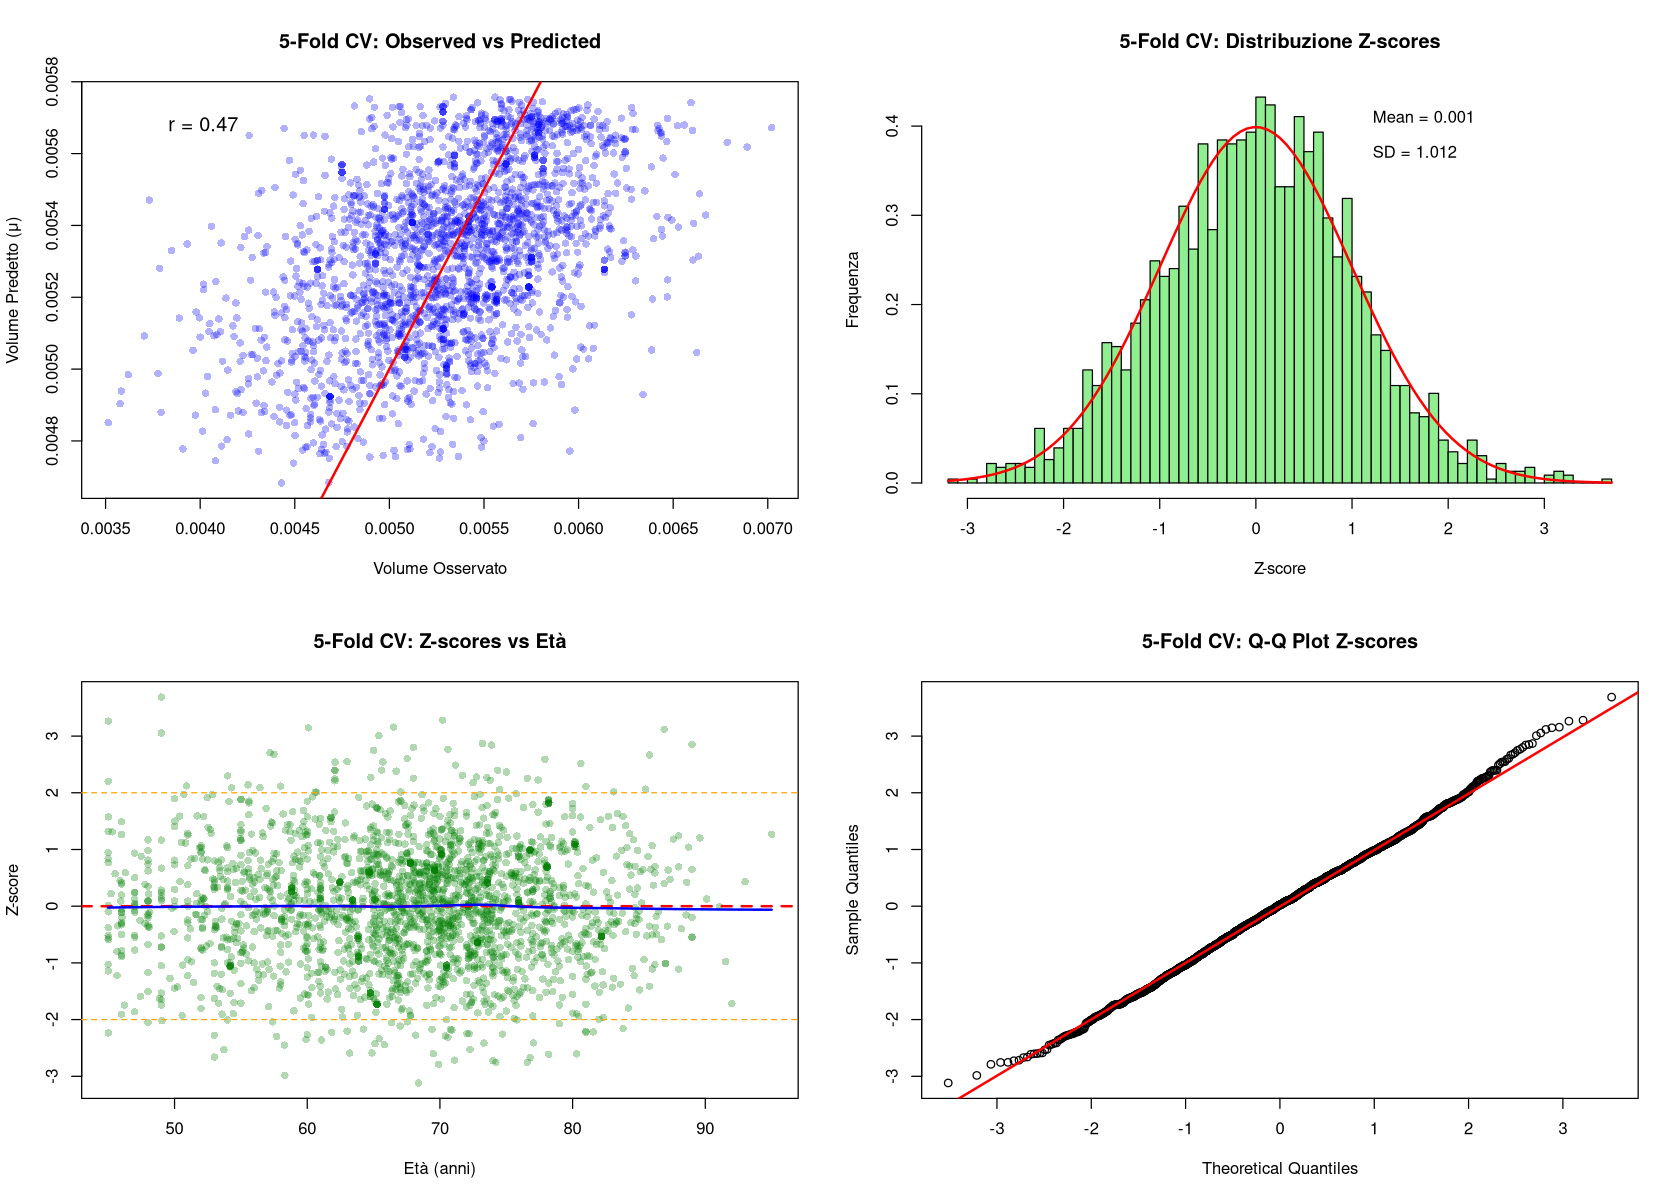

In [14]:
# Visualizzazione risultati 5-fold CV
options(repr.plot.width=14, repr.plot.height=10)
par(mfrow=c(2,2))

# 1. Observed vs Predicted
plot(all_predictions$observed, all_predictions$predicted_mu,
     pch=16, col=rgb(0,0,1,0.3),
     main="5-Fold CV: Observed vs Predicted",
     xlab="Volume Osservato", ylab="Volume Predetto (μ)")
abline(0, 1, col="red", lwd=2)
r_overall <- cor(all_predictions$observed, all_predictions$predicted_mu)
legend("topleft", legend=paste("r =", round(r_overall, 3)), bty="n", cex=1.2)

# 2. Distribuzione Z-scores CV
hist(all_predictions$z_score_cv, breaks=50, col="lightgreen",
     main="5-Fold CV: Distribuzione Z-scores",
     xlab="Z-score", ylab="Frequenza", prob=TRUE)
curve(dnorm(x), add=TRUE, col="red", lwd=2)
legend("topright", legend=c(
  paste("Mean =", round(mean(all_predictions$z_score_cv, na.rm=TRUE), 3)),
  paste("SD =", round(sd(all_predictions$z_score_cv, na.rm=TRUE), 3))
), bty="n")

# 3. Z-scores vs Età (CV)
plot(all_predictions$age, all_predictions$z_score_cv,
     pch=16, col=rgb(0,0.5,0,0.3),
     main="5-Fold CV: Z-scores vs Età",
     xlab="Età (anni)", ylab="Z-score")
abline(h=0, col="red", lwd=2, lty=2)
abline(h=c(-2,2), col="orange", lwd=1, lty=2)
lines(lowess(all_predictions$age, all_predictions$z_score_cv), col="blue", lwd=2)

# 4. Q-Q plot Z-scores CV
qqnorm(all_predictions$z_score_cv, main="5-Fold CV: Q-Q Plot Z-scores")
qqline(all_predictions$z_score_cv, col="red", lwd=2)

par(mfrow=c(1,1))

# Salva figura
png("../figures/gamlss/5fold_cv_diagnostics.png", width=14, height=10, units="in", res=300)
par(mfrow=c(2,2))
plot(all_predictions$observed, all_predictions$predicted_mu,
     pch=16, col=rgb(0,0,1,0.3),
     main="5-Fold CV: Observed vs Predicted",
     xlab="Volume Osservato", ylab="Volume Predetto (μ)")
abline(0, 1, col="red", lwd=2)
legend("topleft", legend=paste("r =", round(r_overall, 3)), bty="n", cex=1.2)
hist(all_predictions$z_score_cv, breaks=50, col="lightgreen",
     main="5-Fold CV: Distribuzione Z-scores",
     xlab="Z-score", ylab="Frequenza", prob=TRUE)
curve(dnorm(x), add=TRUE, col="red", lwd=2)
plot(all_predictions$age, all_predictions$z_score_cv,
     pch=16, col=rgb(0,0.5,0,0.3),
     main="5-Fold CV: Z-scores vs Età",
     xlab="Età (anni)", ylab="Z-score")
abline(h=0, col="red", lwd=2, lty=2)
abline(h=c(-2,2), col="orange", lwd=1, lty=2)
lines(lowess(all_predictions$age, all_predictions$z_score_cv), col="blue", lwd=2)
qqnorm(all_predictions$z_score_cv, main="5-Fold CV: Q-Q Plot Z-scores")
qqline(all_predictions$z_score_cv, col="red", lwd=2)
par(mfrow=c(1,1))
dev.off()

cat("✓ Diagnostic plots 5-fold CV salvati\n")

## 13. Validazione su Dataset Esterno (Template per AABC)

Questa sezione fornisce un template per validare il modello su un dataset esterno (es. AABC) quando sarà disponibile.

**Procedura:**
1. Caricare il dataset esterno con le stesse colonne (`age`, `sex`, `vol_total_hippocampus_norm`)
2. Assegnare un `dataset` di riferimento dal training set per le predizioni
3. Calcolare Z-scores e valutare la calibrazione

In [15]:
# === TEMPLATE PER VALIDAZIONE ESTERNA ===
# Decommentare quando il dataset AABC sarà disponibile

cat("=== VALIDAZIONE SU DATASET ESTERNO (AABC) ===\n\n")

# --- STEP 1: Carica dataset esterno ---
# aabc_file <- "../data/AABC/aabc_processed_volumes.csv"
# 
# if(file.exists(aabc_file)) {
#   df_aabc <- read.csv(aabc_file)
#   
#   # Verifica colonne necessarie
#   required_cols <- c("age", "sex", "vol_total_hippocampus_norm")
#   if(!all(required_cols %in% names(df_aabc))) {
#     stop("Colonne mancanti nel dataset AABC: ", 
#          paste(setdiff(required_cols, names(df_aabc)), collapse=", "))
#   }
#   
#   # Prepara dati
#   df_aabc <- df_aabc %>%
#     select(all_of(required_cols)) %>%
#     na.omit()
#   df_aabc$sex <- as.factor(df_aabc$sex)
#   
#   # Usa ADNI come dataset di riferimento (più simile per protocollo)
#   df_aabc$dataset <- factor("ADNI", levels = levels(df_model$dataset))
#   
#   cat("Dataset AABC caricato:\n")
#   cat("  N soggetti:", nrow(df_aabc), "\n")
#   cat("  Range età:", min(df_aabc$age), "-", max(df_aabc$age), "\n")
#   cat("  Femmine:", sum(df_aabc$sex == "F"), "| Maschi:", sum(df_aabc$sex == "M"), "\n\n")
#   
#   # --- STEP 2: Predizioni con il modello finale ---
#   aabc_mu <- predict(model_final, newdata = df_aabc, what = "mu", type = "response")
#   aabc_sigma <- predict(model_final, newdata = df_aabc, what = "sigma", type = "response")
#   aabc_nu <- predict(model_final, newdata = df_aabc, what = "nu", type = "response")
#   aabc_tau <- predict(model_final, newdata = df_aabc, what = "tau", type = "response")
#   
#   # Calcola Z-scores
#   aabc_percentile <- pBCT(
#     q = df_aabc$vol_total_hippocampus_norm,
#     mu = aabc_mu,
#     sigma = aabc_sigma,
#     nu = aabc_nu,
#     tau = aabc_tau
#   )
#   df_aabc$z_score <- qnorm(aabc_percentile)
#   df_aabc$z_score[aabc_percentile <= 0.0001] <- -4
#   df_aabc$z_score[aabc_percentile >= 0.9999] <- 4
#   
#   # --- STEP 3: Valuta calibrazione ---
#   cat(rep("=", 60), "\n", sep="")
#   cat("VALIDAZIONE ESTERNA - AABC\n")
#   cat(rep("=", 60), "\n", sep="")
#   
#   cat("\nStatistiche Z-scores AABC:\n")
#   cat("  Media:  ", round(mean(df_aabc$z_score, na.rm=TRUE), 3), " (ideale: 0)\n")
#   cat("  SD:     ", round(sd(df_aabc$z_score, na.rm=TRUE), 3), " (ideale: 1)\n")
#   cat("  Mediana:", round(median(df_aabc$z_score, na.rm=TRUE), 3), "\n")
#   
#   cat("\nCalibrazione:\n")
#   cat("  % con |Z| ≤ 2: ", round(mean(abs(df_aabc$z_score) <= 2, na.rm=TRUE) * 100, 1), 
#       "% (atteso: ~95%)\n")
#   cat("  % con |Z| ≤ 1: ", round(mean(abs(df_aabc$z_score) <= 1, na.rm=TRUE) * 100, 1), 
#       "% (atteso: ~68%)\n")
#   
#   # Metriche predittive
#   mae_aabc <- mean(abs(df_aabc$vol_total_hippocampus_norm - aabc_mu))
#   cor_aabc <- cor(df_aabc$vol_total_hippocampus_norm, aabc_mu)
#   cat("\nMetriche predittive:\n")
#   cat("  MAE:        ", round(mae_aabc, 6), "\n")
#   cat("  Correlazione:", round(cor_aabc, 3), "\n")
#   
#   # Salva risultati
#   aabc_output <- "../data/AABC/aabc_with_zscores_external_validation.csv"
#   write.csv(df_aabc, aabc_output, row.names = FALSE)
#   cat("\n✓ Risultati salvati:", aabc_output, "\n")
#   
# } else {
#   cat("⚠️ File AABC non trovato:", aabc_file, "\n")
#   cat("   Questa sezione sarà eseguita quando il dataset sarà disponibile.\n")
# }

cat("⚠️ Sezione template - Decommentare quando il dataset AABC sarà disponibile\n")
cat("\nPer eseguire la validazione esterna:\n")
cat("  1. Preparare il file: ../data/AABC/aabc_processed_volumes.csv\n")
cat("  2. Colonne richieste: age, sex, vol_total_hippocampus_norm\n")
cat("  3. Decommentare il codice sopra e rieseguire la cella\n")

=== VALIDAZIONE SU DATASET ESTERNO (AABC) ===

⚠️ Sezione template - Decommentare quando il dataset AABC sarà disponibile

Per eseguire la validazione esterna:
  1. Preparare il file: ../data/AABC/aabc_processed_volumes.csv
  2. Colonne richieste: age, sex, vol_total_hippocampus_norm
  3. Decommentare il codice sopra e rieseguire la cella
⚠️ Sezione template - Decommentare quando il dataset AABC sarà disponibile

Per eseguire la validazione esterna:
  1. Preparare il file: ../data/AABC/aabc_processed_volumes.csv
  2. Colonne richieste: age, sex, vol_total_hippocampus_norm
  3. Decommentare il codice sopra e rieseguire la cella


## 14. Summary Validazione Completa

Riepilogo di tutte le strategie di validazione implementate.

In [16]:
cat(rep("=", 80), "\n", sep="")
cat("RIEPILOGO VALIDAZIONE MODELLO NORMATIVO\n")
cat(rep("=", 80), "\n", sep="")

cat("\n📊 MODELLO FINALE\n")
cat("   Tipo:           GAMLSS con distribuzione BCT\n")
cat("   Formula mu:     pb(age, df=3) + sex + dataset\n")
cat("   Formula sigma:  ~ age\n")
cat("   N soggetti:    ", nrow(df_model), "\n")
cat("   AIC:           ", round(AIC(model_final), 2), "\n")
cat("   BIC:           ", round(GAIC(model_final, k = log(nrow(df_model))), 2), "\n")

cat("\n", rep("-", 60), "\n", sep="")
cat("📈 LEAVE-ONE-DATASET-OUT CROSS-VALIDATION\n")
cat(rep("-", 60), "\n", sep="")
if(exists("lodo_results") && nrow(lodo_results) > 0) {
  cat("   Datasets testati:  ", nrow(lodo_results), "\n")
  cat("   MAE medio:         ", round(mean(lodo_results$MAE), 6), "\n")
  cat("   Correlazione media:", round(mean(lodo_results$Correlation), 3), "\n")
  cat("\n   Dettaglio per dataset:\n")
  for(i in 1:nrow(lodo_results)) {
    cat("     ", lodo_results$test_dataset[i], ": MAE =", lodo_results$MAE[i], 
        ", r =", lodo_results$Correlation[i], "\n")
  }
} else {
  cat("   ⚠️ Non ancora eseguito\n")
}

cat("\n", rep("-", 60), "\n", sep="")
cat("📈 5-FOLD CROSS-VALIDATION\n")
cat(rep("-", 60), "\n", sep="")
if(exists("cv_results") && nrow(cv_results) > 0) {
  cat("   Folds:             ", nrow(cv_results), "\n")
  cat("   MAE medio:         ", round(mean(cv_results$MAE), 6), " ± ", round(sd(cv_results$MAE), 6), "\n")
  cat("   RMSE medio:        ", round(mean(cv_results$RMSE), 6), " ± ", round(sd(cv_results$RMSE), 6), "\n")
  cat("   Correlazione media:", round(mean(cv_results$Correlation), 3), " ± ", round(sd(cv_results$Correlation), 3), "\n")
  cat("\n   Calibrazione Z-scores (out-of-sample):\n")
  cat("     Media Z:         ", round(mean(cv_results$Z_mean), 3), " (ideale: 0)\n")
  cat("     SD Z:            ", round(mean(cv_results$Z_sd), 3), " (ideale: 1)\n")
  cat("     % within ±2SD:   ", round(mean(cv_results$Pct_within_2SD), 1), "% (ideale: ~95%)\n")
} else {
  cat("   ⚠️ Non ancora eseguito\n")
}

cat("\n", rep("-", 60), "\n", sep="")
cat("📈 VALIDAZIONE ESTERNA (AABC)\n")
cat(rep("-", 60), "\n", sep="")
cat("   Status: In attesa del dataset\n")

cat("\n", rep("=", 80), "\n", sep="")
cat("✅ CONCLUSIONI\n")
cat(rep("=", 80), "\n", sep="")

# Valutazione automatica della qualità
if(exists("cv_results") && exists("lodo_results")) {
  avg_cor <- mean(c(mean(cv_results$Correlation), mean(lodo_results$Correlation)))
  avg_z_sd <- mean(cv_results$Z_sd)
  avg_pct_2sd <- mean(cv_results$Pct_within_2SD)
  
  cat("\n🔍 Valutazione automatica:\n")
  
  # Correlazione
  if(avg_cor >= 0.8) {
    cat("   ✅ Correlazione: ECCELLENTE (r =", round(avg_cor, 3), ")\n")
  } else if(avg_cor >= 0.6) {
    cat("   ⚠️ Correlazione: BUONA (r =", round(avg_cor, 3), ")\n")
  } else {
    cat("   ❌ Correlazione: INSUFFICIENTE (r =", round(avg_cor, 3), ")\n")
  }
  
  # Calibrazione SD
  if(abs(avg_z_sd - 1) <= 0.1) {
    cat("   ✅ Calibrazione SD: ECCELLENTE (SD =", round(avg_z_sd, 3), ")\n")
  } else if(abs(avg_z_sd - 1) <= 0.2) {
    cat("   ⚠️ Calibrazione SD: BUONA (SD =", round(avg_z_sd, 3), ")\n")
  } else {
    cat("   ❌ Calibrazione SD: DA MIGLIORARE (SD =", round(avg_z_sd, 3), ")\n")
  }
  
  # Copertura 95%
  if(abs(avg_pct_2sd - 95) <= 2) {
    cat("   ✅ Copertura ±2SD: ECCELLENTE (", round(avg_pct_2sd, 1), "%)\n")
  } else if(abs(avg_pct_2sd - 95) <= 5) {
    cat("   ⚠️ Copertura ±2SD: BUONA (", round(avg_pct_2sd, 1), "%)\n")
  } else {
    cat("   ❌ Copertura ±2SD: DA VERIFICARE (", round(avg_pct_2sd, 1), "%)\n")
  }
}

cat("\n📋 File salvati:\n")
cat("   - ../models/gamlss_bct_hippocampus_model.rds\n")
cat("   - ../models/model_comparison.csv\n")
cat("   - ../models/lodo_cross_validation_results.csv\n")
cat("   - ../models/5fold_cross_validation_results.csv\n")
cat("   - ../data/combined/normative_dataset_with_zscores_gamlss.csv\n")
cat("   - ../figures/gamlss/*.png\n")

cat("\n", rep("=", 80), "\n", sep="")

RIEPILOGO VALIDAZIONE MODELLO NORMATIVO

📊 MODELLO FINALE
   Tipo:           GAMLSS con distribuzione BCT
   Formula mu:     pb(age, df=3) + sex + dataset
   Formula sigma:  ~ age
   N soggetti:     2289 
   AIC:            -28898.93 
   BIC:            -28812.89 

📊 MODELLO FINALE
   Tipo:           GAMLSS con distribuzione BCT
   Formula mu:     pb(age, df=3) + sex + dataset
   Formula sigma:  ~ age
   N soggetti:     2289 
   AIC:            -28898.93 
   BIC:            -28812.89 

------------------------------------------------------------

------------------------------------------------------------
📈 LEAVE-ONE-DATASET-OUT CROSS-VALIDATION
------------------------------------------------------------
   Datasets testati:   6 
   MAE medio:          0.000354 
   Correlazione media: 0.412 

   Dettaglio per dataset:
      ADNI : MAE = 0.00038 , r = 0.382 
      IXI : MAE = 0.000341 , r = 0.382 
      OASIS2 : MAE = 0.000412 , r = 0.394 
      OASIS3 : MAE = 0.000348 , r = 0.456 
  

## Next Steps

### ✅ Validazione del Modello (COMPLETATA)
1. ~~**Cross-validation**: Implementare 5-fold CV per valutare generalizzazione~~ → Sezione 12
2. ~~**Leave-one-dataset-out**: Testare su dataset esclusi dal training~~ → Sezione 11
3. **External validation**: Validare su AABC quando disponibile → Template in Sezione 13

### Estensioni del Modello
1. **Multi-regional**: Estendere ad amygdala, entorhinal cortex, ventricles
2. **Longitudinal**: Modellare traiettorie individuali nel tempo
3. **Advanced distributions**: Testare BCPE, BCCGo per asimmetrie estreme

### Applicazioni Cliniche
1. **AD/MCI cohorts**: Applicare a pazienti Alzheimer e MCI
2. **ROC analysis**: Valutare accuratezza diagnostica degli Z-scores

## Riferimenti

### GAMLSS:
- Rigby & Stasinopoulos (2005). *Generalized additive models for location, scale and shape*. JRSS-C, 54(3), 507-554.
- Stasinopoulos & Rigby (2007). *Generalized additive models for location scale and shape (GAMLSS) in R*. JSS, 23(7), 1-46.

### Normative Modeling:
- Bethlehem et al. (2022). *Brain charts for the human lifespan*. Nature, 604, 525-533.
- Marquand et al. (2016). *Understanding heterogeneity in clinical cohorts using normative models*. Biol Psychiatry, 80(7), 552-561.

### Hippocampal Volumetry:
- Jack Jr et al. (2015). *Age, sex, and APOE ε4 effects on memory and brain structure*. JAMA Neurology, 72(5), 511-519.
- Nobis et al. (2019). *Hippocampal volume across age*. NeuroImage Clinical, 23, 101904.

## 15. Esportazione Modello per Python

Esportiamo tutti i parametri necessari per ricostruire il modello GAMLSS in Python. Questo include:
- Coefficienti per μ, σ, ν, τ
- Knots e basi delle penalized splines
- Lookup table per predizioni rapide

In [22]:
# =============================================================================
# ESPORTAZIONE MODELLO PER PYTHON
# =============================================================================
# Questo codice esporta tutti i parametri necessari per usare il modello in Python

library(jsonlite)

cat("=== ESPORTAZIONE MODELLO PER PYTHON ===\n\n")

# Debug: verifica colonne disponibili
cat("Colonne disponibili in df_model:\n")
print(names(df_model))
cat("\n")

# 1. Estrai coefficienti del modello
mu_coef <- coef(model_final, what = "mu")
sigma_coef <- coef(model_final, what = "sigma")
nu_coef <- coef(model_final, what = "nu")
tau_coef <- coef(model_final, what = "tau")

cat("Coefficienti estratti:\n")
cat("  μ (mu):", length(mu_coef), "coefficienti\n")
cat("  σ (sigma):", length(sigma_coef), "coefficienti\n")
cat("  ν (nu):", length(nu_coef), "coefficienti\n")
cat("  τ (tau):", length(tau_coef), "coefficienti\n")

# 2. Crea lookup table usando i dati fittati
# Approccio: per ogni combinazione dataset/sex, fitta una spline sui valori fittati
# e usa quella per predire sulla griglia di età

age_grid <- seq(45, 95, by = 0.5)
datasets <- levels(df_model$dataset)
sexes <- levels(df_model$sex)

cat("\nCreazione lookup table da valori fittati...\n")

# Lista per raccogliere i risultati
lookup_list <- list()

for (d in datasets) {
  for (s in sexes) {
    # Filtra dati training per dataset e sesso
    subset <- df_model[df_model$dataset == d & df_model$sex == s, ]
    subset <- subset[order(subset$age), ]  # Ordina per età
    
    if (nrow(subset) >= 2) {
      # Crea interpolatori per mu e sigma
      # Usa spline se abbastanza punti, altrimenti interpolazione lineare
      
      if (nrow(subset) >= 4) {
        # Smooth spline
        sp_mu <- smooth.spline(subset$age, subset$fitted_mu, df = min(4, nrow(subset)-1))
        sp_sigma <- smooth.spline(subset$age, subset$fitted_sigma, df = min(4, nrow(subset)-1))
        
        mu_pred <- predict(sp_mu, age_grid)$y
        sigma_pred <- predict(sp_sigma, age_grid)$y
      } else {
        # Interpolazione lineare
        mu_pred <- approx(subset$age, subset$fitted_mu, xout = age_grid, rule = 2)$y
        sigma_pred <- approx(subset$age, subset$fitted_sigma, xout = age_grid, rule = 2)$y
      }
      
      # nu e tau sono costanti nel modello
      nu_val <- mean(subset$fitted_nu)
      tau_val <- mean(subset$fitted_tau)
      
      # Crea dataframe per questa combinazione
      temp_df <- data.frame(
        age = age_grid,
        sex = s,
        dataset = d,
        mu = mu_pred,
        sigma = sigma_pred,
        nu = nu_val,
        tau = tau_val
      )
      
      lookup_list[[length(lookup_list) + 1]] <- temp_df
    }
  }
}

# Combina tutti i risultati
lookup_data <- do.call(rbind, lookup_list)

# Converti in fattori con livelli corretti
lookup_data$sex <- factor(lookup_data$sex, levels = levels(df_model$sex))
lookup_data$dataset <- factor(lookup_data$dataset, levels = levels(df_model$dataset))

cat("\nLookup table creata:\n")
cat("  Righe:", nrow(lookup_data), "\n")
cat("  Età range:", min(lookup_data$age), "-", max(lookup_data$age), "\n")
cat("  Dataset:", paste(unique(lookup_data$dataset), collapse = ", "), "\n")
cat("  Combinazioni dataset/sex:", length(lookup_list), "\n")

# Verifica che mu cambi con l'età
cat("\nVerifica variazione μ con età (primo dataset/sex disponibile):\n")
first_combo <- lookup_data[lookup_data$dataset == lookup_data$dataset[1] & 
                           lookup_data$sex == lookup_data$sex[1], ]
cat("  Dataset:", as.character(first_combo$dataset[1]), ", Sex:", as.character(first_combo$sex[1]), "\n")
cat("  Età 50: μ =", round(first_combo$mu[first_combo$age == 50], 6), "\n")
cat("  Età 70: μ =", round(first_combo$mu[first_combo$age == 70], 6), "\n")
cat("  Età 90: μ =", round(first_combo$mu[first_combo$age == 90], 6), "\n")

# Verifica che sigma cambi con l'età
cat("\nVerifica variazione σ con età:\n")
cat("  Età 50: σ =", round(first_combo$sigma[first_combo$age == 50], 6), "\n")
cat("  Età 70: σ =", round(first_combo$sigma[first_combo$age == 70], 6), "\n")
cat("  Età 90: σ =", round(first_combo$sigma[first_combo$age == 90], 6), "\n")

# 3. Prepara oggetto JSON con tutti i parametri
model_export <- list(
  model_info = list(
    type = "GAMLSS",
    family = "BCT",
    formula_mu = "pb(age, df=3) + sex + dataset",
    formula_sigma = "age",
    formula_nu = "1",
    formula_tau = "1",
    n_subjects = nrow(df_model),
    age_range = c(min(df_model$age), max(df_model$age)),
    datasets = as.character(datasets),
    created = as.character(Sys.time())
  ),
  
  coefficients = list(
    mu = as.list(mu_coef),
    sigma = as.list(sigma_coef),
    nu = as.list(nu_coef),
    tau = as.list(tau_coef)
  ),
  
  # Livelli dei fattori (per encoding corretto in Python)
  factor_levels = list(
    sex = levels(df_model$sex),
    dataset = levels(df_model$dataset)
  ),
  
  # Statistiche di normalizzazione (se servono)
  normalization = list(
    age_mean = mean(df_model$age),
    age_sd = sd(df_model$age),
    target_var = target_var
  )
)

# 4. Salva JSON con parametri
json_path <- "../models/gamlss_model_params.json"
write_json(model_export, json_path, pretty = TRUE, auto_unbox = TRUE)
cat("\n✓ Parametri modello salvati in:", json_path, "\n")

# 5. Salva lookup table come CSV (più facile da usare in Python)
lookup_path <- "../models/gamlss_lookup_table.csv"
write.csv(lookup_data, lookup_path, row.names = FALSE)
cat("✓ Lookup table salvata in:", lookup_path, "\n")

# 6. Salva anche dataset training con z-scores per validazione
# Costruisci il vettore di colonne in modo corretto
cols_to_export <- c("subject_id", "age", "sex", "dataset", 
                    target_var, "z_score", 
                    "fitted_mu", "fitted_sigma", "fitted_nu", "fitted_tau")

# Verifica quali colonne esistono effettivamente
cols_available <- cols_to_export[cols_to_export %in% names(df_model)]
cols_missing <- cols_to_export[!cols_to_export %in% names(df_model)]

if (length(cols_missing) > 0) {
  cat("\n⚠ Colonne mancanti:", paste(cols_missing, collapse=", "), "\n")
  cat("  Esporto solo le colonne disponibili.\n")
}

training_export <- df_model[, cols_available]
training_path <- "../models/gamlss_training_data_with_predictions.csv"
write.csv(training_export, training_path, row.names = FALSE)
cat("✓ Training data salvato in:", training_path, "\n")
cat("  Colonne esportate:", paste(cols_available, collapse=", "), "\n")

cat("\n", rep("=", 80), "\n", sep="")
cat("ESPORTAZIONE COMPLETATA\n")
cat(rep("=", 80), "\n", sep="")
cat("\nFile creati per Python:\n")
cat("  1. gamlss_model_params.json    - Coefficienti e metadati modello\n")
cat("  2. gamlss_lookup_table.csv     - Tabella predizioni pre-calcolate\n")
cat("  3. gamlss_training_data_with_predictions.csv - Dati training con z-scores\n")
cat("\nUsa il notebook '11_apply_normative_model_python.ipynb' per applicare il modello in Python.\n")

=== ESPORTAZIONE MODELLO PER PYTHON ===

Colonne disponibili in df_model:
 [1] "age"                        "sex"                       
 [3] "dataset"                    "vol_total_hippocampus_norm"
 [5] "fitted_mu"                  "fitted_sigma"              
 [7] "fitted_nu"                  "fitted_tau"                
 [9] "percentile"                 "z_score"                   

Coefficienti estratti:
  μ (mu): 8 coefficienti
  σ (sigma): 2 coefficienti
  ν (nu): 1 coefficienti
Colonne disponibili in df_model:
 [1] "age"                        "sex"                       
 [3] "dataset"                    "vol_total_hippocampus_norm"
 [5] "fitted_mu"                  "fitted_sigma"              
 [7] "fitted_nu"                  "fitted_tau"                
 [9] "percentile"                 "z_score"                   

Coefficienti estratti:
  μ (mu): 8 coefficienti
  σ (sigma): 2 coefficienti
  ν (nu): 1 coefficienti
  τ (tau): 1 coefficienti

Creazione lookup table da valori